# Integral Field Spectroscopy (IFU)

This notebook deals with Integral Field Unit (IFU) spectroscopy data analysis for astrophysics observations. We'll handle FITS cubes and visualize different properties of a galaxy. Let's start importing the packages needed:

In [43]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import center_of_mass
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.modeling import models, fitting
import imageio
from matplotlib import cm
from IPython.display import Image, display
from scipy.constants import c
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import curve_fit
from scipy.constants import G
from scipy.interpolate import UnivariateSpline

## Loading FITS Data Cube

In this section, we load the FITS data cube containing spectral data of a galaxy. FITS (Flexible Image Transport System) files are commonly used in astronomy.

In [2]:
# Open FITS file
hdul = fits.open('ESO113-G032.fits')

## Reading Header and Data

In [3]:
# Extract header and data
img = hdul[1]  
hdr = img.header
data = img.data
hdr

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  408 / length of data axis 1                          
NAXIS2  =                  327 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ZBLANK  =          -2147483647 / null value in the compressed integer array     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

### Extracting Header Information

We extract relevant metadata from the FITS header, including dimensions, axis lengths, pixel scale, and wavelength step.

In [4]:
# Get dimensions from header
nx, ny, nz = hdr['NAXIS1'], hdr['NAXIS2'], hdr['NAXIS3']
hdr_dims = (nx, ny, nz)
data_dims = data.shape

# Compare dimensions
print("Header dimensions:", hdr_dims)
print("Data dimensions:", data_dims)

if hdr_dims == data_dims:
    print("Header matches data dimensions.")
else:
    print("Warning: Header does NOT match data dimensions.")

Header dimensions: (408, 327, 3681)
Data dimensions: (3681, 327, 408)


## Dimension Analysis and Axis Correspondence

Based on the header dimensions `(408, 327, 3681)` and the actual data dimensions `(3681, 327, 408)`, we observe that the header and data dimensions do **not match** directly.

This discrepancy suggests that the axes are ordered differently between the header information and the actual data array. Typically, FITS data cubes for Integral Field Spectroscopy are structured as `(Wavelength, DEC, RA)` in the data array, while the header might list them differently (`RA`, `DEC`, `Wavelength`).

**Axis correspondence inferred from the data:**

- **Axis 0** (3681 elements): Corresponds clearly to the **spectral axis (Wavelength)**.
- **Axis 1** (327 elements): Corresponds to the spatial axis (**Declination**).
- **Axis 2** (408 elements): Corresponds to the spatial axis (**Right Ascension**).
 
The header dimensions are ordered differently from the data cube itself. The spectral axis is the first dimension in the data cube array (`axis=0`). Therefore, the correct order of axes in your data cube is:

**`(Wavelength, DEC, RA)`**

This implies you should be careful when indexing your data for further analysis, ensuring that you always follow the `(λ, DEC, RA)` convention.


## Galaxy Images at Different Wavelengths

We visualize the galaxy at multiple wavelengths to observe how its appearance changes across the spectral range covered by the data cube. 

Before visualizing images at specific wavelengths, we define conversion functions:  
- **`pix_to_ra(x)` and `pix_to_dec(y)`** transform pixel coordinates into celestial coordinates (Right Ascension and Declination). This step is crucial to accurately position and label astronomical objects spatially.
- **`pix_to_wl(z)`** converts spectral pixel indices into physical wavelengths (Angstrom). This allows us to visualize images at scientifically meaningful wavelengths rather than at arbitrary pixel indices.

These transformations rely on header parameters (`CRVAL`, `CRPIX`, and `CD`) obtained from the FITS header. Such transformations ensure proper spatial referencing and wavelength calibration for accurate astronomical analysis.

Then, we define a custom function named `imstats` to calculate the mean and standard deviation of flux values in a central region of each image slice. This function helps us set appropriate limits (`vmin`, `vmax`) for visualization.
After that, we choose three representative wavelengths to create 2D spatial images from the data cube.
Finally, we plot these images side by side, clearly labeling each with its corresponding wavelength and coordinate axes (RA and Dec in pixels), allowing us to examine morphological changes at different wavelengths.


In [5]:
# Coordinate transformation params
crv1, crv2, crv3 = hdr['CRVAL1'], hdr['CRVAL2'], hdr['CRVAL3']
crp1, crp2, crp3 = hdr['CRPIX1'], hdr['CRPIX2'], hdr['CRPIX3']
cd1, cd2, cd3 = hdr['CD1_1'], hdr['CD2_2'], hdr['CD3_3']

# Pixel to physical coordinate conversion
def pix_to_ra(x):
    return cd1 * (x - crp1) + crv1

def pix_to_dec(y):
    return cd2 * (y - crp2) + crv2

def pix_to_wl(z):
    return cd3 * (z - crp3) + crv3

In [6]:
# Function to compute image statistics in the central region
def imstats(image, center_frac=0.5):
    ny, nx = image.shape
    cy, cx = int(ny * (1 - center_frac) / 2), int(nx * (1 - center_frac) / 2)
    cropped = image[cy:-cy, cx:-cx]  # Extract central region
    mean, std = np.mean(cropped), np.std(cropped)
    return mean, std

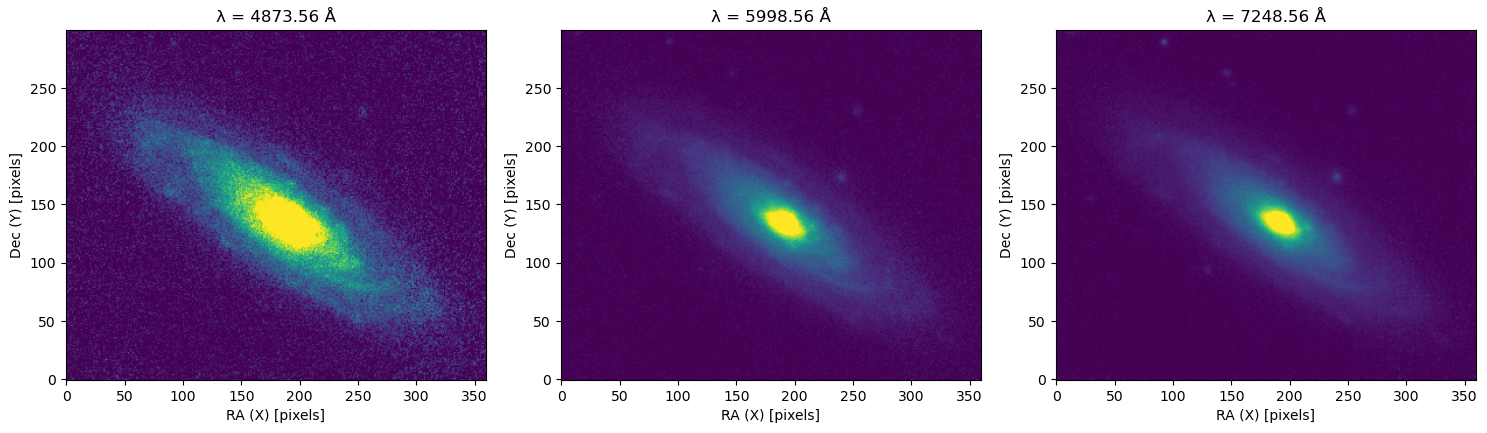

In [7]:
# Selection of wavelength indices
wl_idxs = [100, 1000, 2000]

# Convert indices to Angstroms
wavelengths = [pix_to_wl(idx) for idx in wl_idxs]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (idx, wl) in enumerate(zip(wl_idxs, wavelengths)):
    img_slice = data[idx, :, :]
    mean, std = imstats(img_slice)  # Compute stats in central region
    
    axes[i].imshow(img_slice[10:310,30:390], origin='lower', vmin=0, vmax=mean + 1.11**std)
    axes[i].set_title(f'λ = {wl:.2f} Å')
    axes[i].set_xlabel('RA (X) [pixels]')
    axes[i].set_ylabel('Dec (Y) [pixels]')

plt.tight_layout()
plt.show()

## Spectra at Selected Pixels

In this section, we select a few representative pixels from different galaxy regions (center, intermediate, and outskirts) and plot their spectra. This visualization helps identify differences in emission or absorption features across spatial positions.


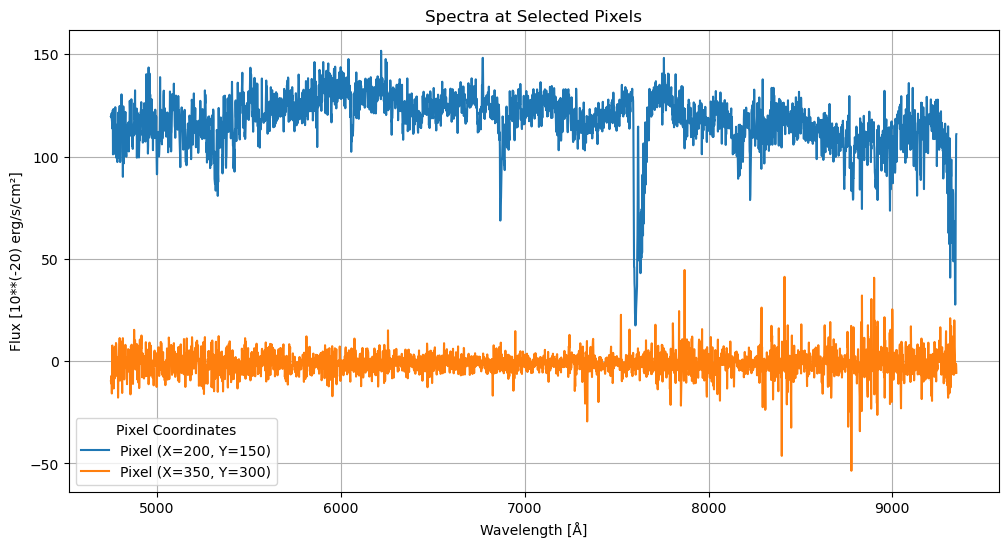

In [8]:
# Select specific pixel coordinates (center and outskirts)
pixel_coords = [(150, 200), (300, 350)]  

# Plotting spectra at the selected pixels
plt.figure(figsize=(12, 6))

for y, x in pixel_coords:
    spectrum = data[:, y, x]
    wavelength_axis = pix_to_wl(np.arange(data.shape[0]))
    plt.plot(wavelength_axis, spectrum, label=f'Pixel (X={x}, Y={y})')

plt.title('Spectra at Selected Pixels')
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux [10**(-20) erg/s/cm²]')
plt.legend(title='Pixel Coordinates')
plt.grid(True)
plt.show()

We observed clear differences between the spectra extracted at different galaxy pixels. The central region (blue spectrum) exhibits higher flux and stronger emission and absorption lines, indicating active regions with possibly intense star formation activity or central galactic activity. On the other hand, spectra from peripheral regions (orange line) show significantly lower flux, suggesting that these areas have weaker emission and potentially different stellar populations or less gas content.

## Creating a Moment-0 (White) Image

A moment-0 or "white" image is created by summing the flux across all wavelength layers, highlighting the galaxy's overall brightness distribution without spectral discrimination. We also use this image to identify the galaxy center, typically by comparing it to known external coordinates (e.g., from astronomical databases such as NED). First step is to get the coordinates and the name of our galaxy and compare with NED

In [9]:
galaxy_name = hdr.get('OBJECT', 'Unknown')
ra, dec = hdr['CRVAL1'], hdr['CRVAL2']
print(f"Galaxy Name: {galaxy_name}")
print(f"RA: {ra}, DEC: {dec}")

Galaxy Name: ASASSN14ig_1 (DATA)
RA: 19.025833, DEC: -61.62083


Are the same coordinates than in NED

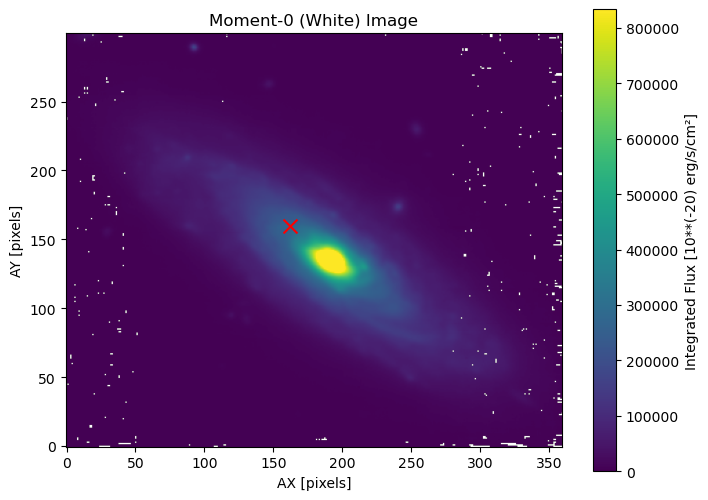

In [10]:
# Calculate Moment-0 (white) image by summing flux across wavelengths
moment0_image = np.sum(data, axis=0)
mean, std = imstats(moment0_image[10:310,30:390])

# WCS information for the spatial coordinates only (RA and Dec axes)
wcs = WCS(hdr, naxis=2)

# Convert coordinates to pixel coordinates (correct syntax)
galaxy_x, galaxy_y = wcs.world_to_pixel_values(ra, dec)

# Plotting the Moment-0 image clearly showing the galaxy center
plt.figure(figsize=(8, 6))
plt.imshow(moment0_image[10:310,30:390], vmin=0, vmax=mean + 4.*std, origin='lower')
plt.colorbar(label='Integrated Flux [10**(-20) erg/s/cm²]')
plt.scatter(galaxy_x, galaxy_y, color='red', marker='x', s=100, label='Galaxy Center')
plt.title('Moment-0 (White) Image')
plt.xlabel('AX [pixels]')
plt.ylabel('AY [pixels]')
plt.show()

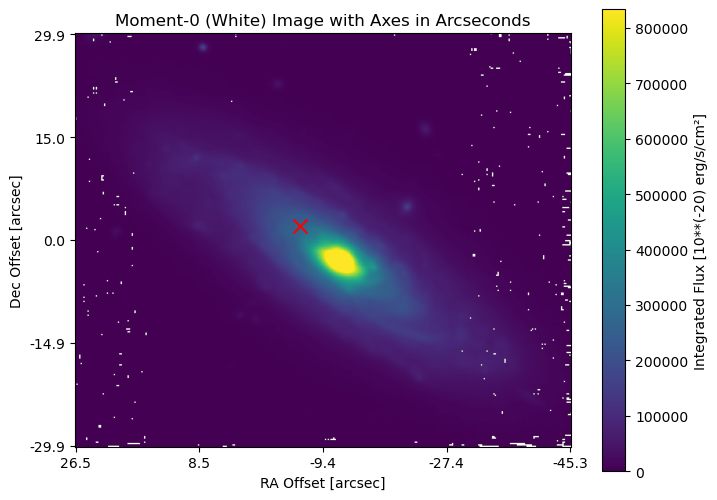

In [11]:
# Convert pixel coordinates to arcseconds
ra_arcsec = (np.arange(30, 390) - galaxy_x) * cd1 * 3600  # Convert degrees to arcsec
dec_arcsec = (np.arange(10, 310) - galaxy_y) * cd2 * 3600  # Convert degrees to arcsec

# Plot Moment-0 image with axes in arcseconds
plt.figure(figsize=(8, 6))
plt.imshow(moment0_image[10:310, 30:390], origin='lower', vmin=0, vmax=mean + 4.*std)
plt.colorbar(label='Integrated Flux [10**(-20) erg/s/cm²]')

# Adjust tick labels to arcseconds
plt.xticks(ticks=np.linspace(0, len(ra_arcsec)-1, 5), labels=np.round(np.linspace(ra_arcsec[0], ra_arcsec[-1], 5), 1))
plt.yticks(ticks=np.linspace(0, len(dec_arcsec)-1, 5), labels=np.round(np.linspace(dec_arcsec[0], dec_arcsec[-1], 5), 1))
plt.scatter(galaxy_x, galaxy_y, color='red', marker='x', s=100, label='Galaxy Center')
plt.title('Moment-0 (White) Image with Axes in Arcseconds')
plt.xlabel('RA Offset [arcsec]')
plt.ylabel('Dec Offset [arcsec]')
plt.show()

The Moment-0 (White) image effectively shows the integrated flux across all wavelengths, clearly highlighting the brightest central region of the galaxy. However, discrepancies between provided coordinates and the observed peak brightness might require recalculating the center directly from the data to ensure accurate alignment in subsequent analysis. Let's check it:

In [12]:
# Calculate Moment-0 (white) image
moment0_image = np.sum(data, axis=0)

# Define a clean central subregion (adjust as needed)
subregion = moment0_image[110:250, 150:260]

# Compute flux-weighted centroid (robust calculation)
subregion_centroid_y, subregion_centroid_x = center_of_mass(subregion)

# Adjust centroid coordinates to match full image coordinates
galaxy_y_recalc = 101 + subregion_centroid_y
galaxy_x_recalc = 161 + subregion_centroid_x

print(f"Flux-weighted centroid coordinates: X={subregion_centroid_x:.2f}, Y={subregion_centroid_y:.2f}")

Flux-weighted centroid coordinates: X=60.48, Y=44.01


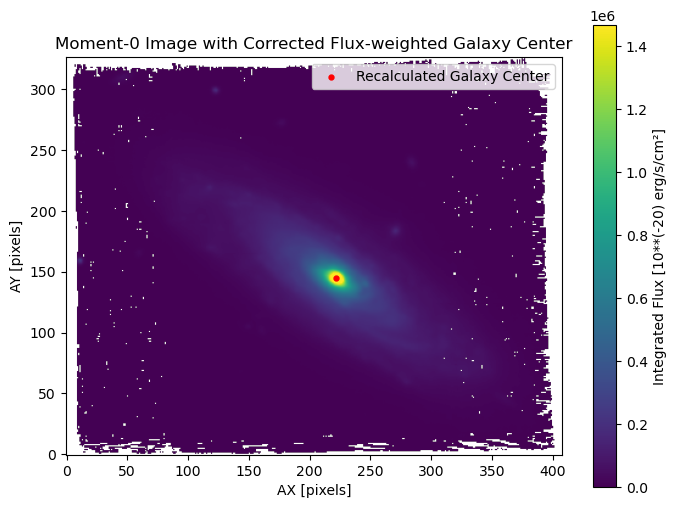

In [13]:
# Plotting Moment-0 image with the recalculated centroid
plt.figure(figsize=(8, 6))
plt.imshow(moment0_image, origin='lower', vmin=0, vmax=mean + 7.5*std)
plt.colorbar(label='Integrated Flux [10**(-20) erg/s/cm²]')
plt.scatter(galaxy_x_recalc, galaxy_y_recalc, 
            color='red', marker='.', s=50, label='Recalculated Galaxy Center')
plt.title('Moment-0 Image with Corrected Flux-weighted Galaxy Center')
plt.xlabel('AX [pixels]')
plt.ylabel('AY [pixels]')
plt.legend()
plt.show()

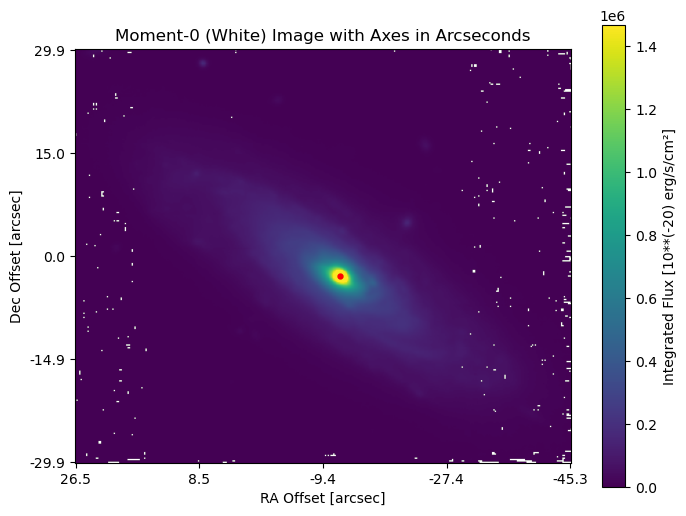

In [14]:
# Plot Moment-0 image with axes in arcseconds
plt.figure(figsize=(8, 6))
plt.imshow(moment0_image[10:310, 30:390], origin='lower', vmin=0, vmax=mean + 7.5*std)
plt.colorbar(label='Integrated Flux [10**(-20) erg/s/cm²]')

# Adjust tick labels to arcseconds
plt.xticks(ticks=np.linspace(0, len(ra_arcsec)-1, 5), labels=np.round(np.linspace(ra_arcsec[0], ra_arcsec[-1], 5), 1))
plt.yticks(ticks=np.linspace(0, len(dec_arcsec)-1, 5), labels=np.round(np.linspace(dec_arcsec[0], dec_arcsec[-1], 5), 1))
plt.scatter(galaxy_x_recalc-30, galaxy_y_recalc-10, color='red', marker='.', s=50, label='Galaxy Center')
plt.title('Moment-0 (White) Image with Axes in Arcseconds')
plt.xlabel('RA Offset [arcsec]')
plt.ylabel('Dec Offset [arcsec]')
plt.show()

## Galaxy Images in r and i Bands (Magnitudes)

This exercise involves creating images of the galaxy in the Sloan Digital Sky Survey (SDSS) `r` and `i` bands. To do this, we integrate the flux from the data cube over the wavelength ranges specific to each photometric band. We then convert these integrated fluxes to astronomical magnitudes using the ST magnitude system with the following formula:
$
m_{\text{STMAG}} = -2.5 \log(f_\lambda) - 21.1
$

where $ f_{\lambda} $ is the integrated flux in units of $erg/s/cm²/Å$.

The wavelength intervals for each band are:
- `r-band`: 5500 Å to 7000 Å
- `i-band`: 7000 Å to 8500 Å

After converting to magnitudes, we visualize the galaxy images clearly labeling their spatial dimensions in arcseconds.

/var/folders/t8/k7slklj17w76s6xvhxf295pr0000gn/T/ipykernel_13173/1882527310.py:18: RuntimeWarning: invalid value encountered in log10
  r_mag_image = -2.5 * np.log10(r_band_image) - 21.1
/var/folders/t8/k7slklj17w76s6xvhxf295pr0000gn/T/ipykernel_13173/1882527310.py:19: RuntimeWarning: invalid value encountered in log10
  i_mag_image = -2.5 * np.log10(i_band_image) - 21.1


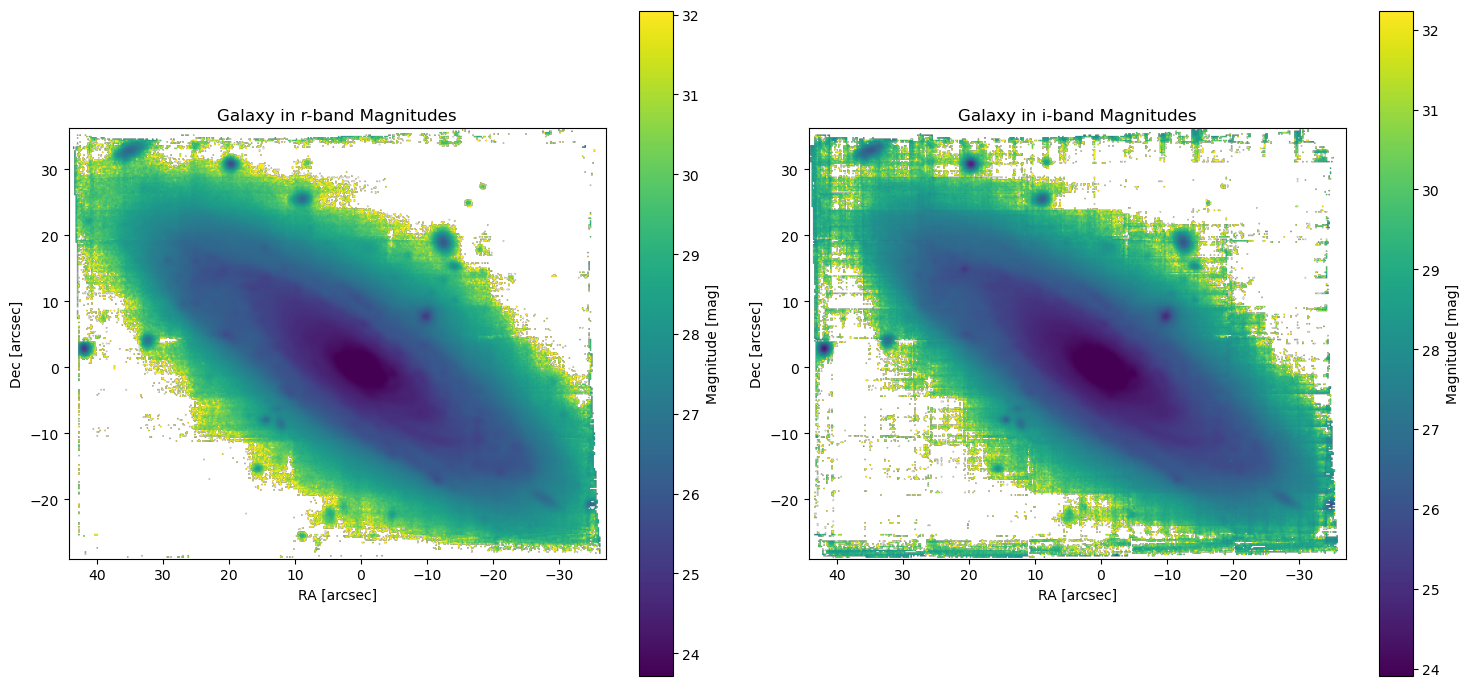

In [15]:
# Define wavelength conversion
z = np.arange(data.shape[0])
lambdas = pix_to_wl(z)

# Define wavelength intervals for r and i bands
r_band_range = (5500, 7000)
i_band_range = (7000, 8500)

# Integrate flux across wavelength ranges to obtain images and normalize
r_band_image = np.sum(data[(wavelength_axis >= r_band_range[0]) & (wavelength_axis <= r_band_range[1]), :, :], axis=0) / (r_band_range[1] - r_band_range[0])
i_band_image = np.sum(data[(wavelength_axis >= i_band_range[0]) & (wavelength_axis <= i_band_range[1]), :, :], axis=0) / (i_band_range[1] - i_band_range[0])

# Normalize and scale flux by 10^-20 for magnitude conversion
r_band_image *= 1e-20
i_band_image *= 1e-20

# Convert integrated flux images to magnitudes (ST magnitude system)
r_mag_image = -2.5 * np.log10(r_band_image) - 21.1
i_mag_image = -2.5 * np.log10(i_band_image) - 21.1

# Compute image statistics
r_mean, r_std = np.nanmean(r_mag_image), np.nanstd(r_mag_image)
i_mean, i_std = np.nanmean(i_mag_image), np.nanstd(i_mag_image)

# Coordinate conversion to arcseconds
wcs = WCS(hdr, naxis=2)
x_axis_arcsec = (np.arange(nx) - galaxy_x_recalc) * hdr['CD1_1'] * 3600
y_axis_arcsec = (np.arange(ny) - galaxy_y_recalc) * hdr['CD2_2'] * 3600

# Plot the images in magnitudes with adjusted vmin and vmax
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

im0 = axs[0].imshow(r_mag_image, origin='lower', extent=[x_axis_arcsec[0], x_axis_arcsec[-1], y_axis_arcsec[0], y_axis_arcsec[-1]], vmin=r_mean - 2*i_std, vmax=r_mean + 2*i_std)
axs[0].set_title('Galaxy in r-band Magnitudes')
axs[0].set_xlabel('RA [arcsec]')
axs[0].set_ylabel('Dec [arcsec]')
plt.colorbar(im0, ax=axs[0], label='Magnitude [mag]')

im1 = axs[1].imshow(i_mag_image, origin='lower', extent=(x_axis_arcsec[0], x_axis_arcsec[-1], y_axis_arcsec[0], y_axis_arcsec[-1]), vmin=i_mean - 2*i_std, vmax=i_mean + 2*i_std)
axs[1].set_title('Galaxy in i-band Magnitudes')
axs[1].set_xlabel('RA [arcsec]')
axs[1].set_ylabel('Dec [arcsec]')
plt.colorbar(im1, ax=axs[1], label='Magnitude [mag]')

plt.tight_layout()
plt.show()

## r-i color image

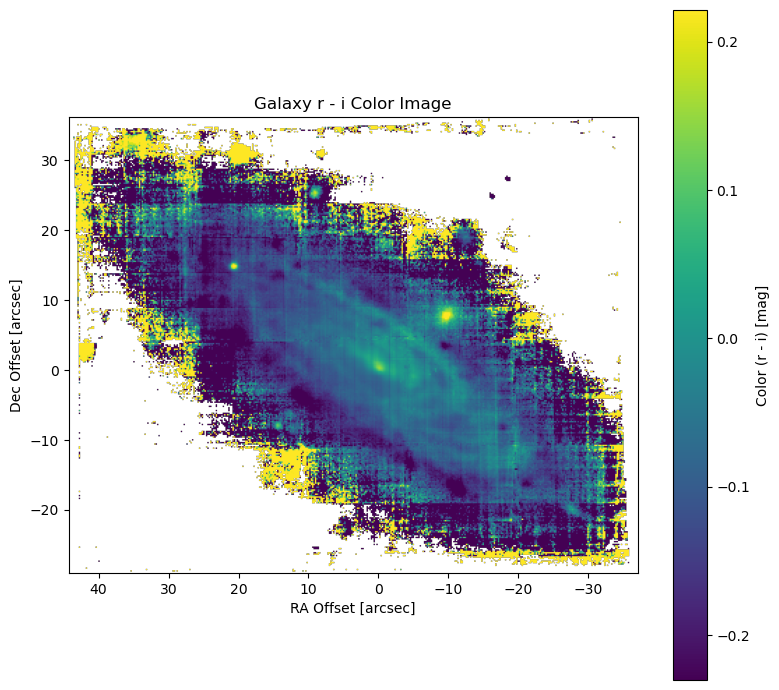

In [16]:
# Calculate r - i color image
color_image = r_mag_image - i_mag_image

# Compute statistics for color image
color_mean, color_std = np.nanmean(color_image), np.nanstd(color_image)

# Plot r - i color image
plt.figure(figsize=(8, 7))
plt.imshow(color_image, origin='lower', extent=[x_axis_arcsec[0], x_axis_arcsec[-1], y_axis_arcsec[0], y_axis_arcsec[-1]], vmin=color_mean - 0.2*color_std, vmax=color_mean + 0.5*color_std)
plt.title('Galaxy r - i Color Image')
plt.xlabel('RA Offset [arcsec]')
plt.ylabel('Dec Offset [arcsec]')
cbar = plt.colorbar(label='Color (r - i) [mag]')
plt.tight_layout()
plt.show()

**Interpretation of the Galaxy r-i Color Image**

The \( r - i \) color image highlights the distribution of stellar populations within the galaxy:

- **Redder regions (higher r-i values)** are typically found in the galaxy's central bulge and inner regions. These areas contain older, cooler stellar populations, indicative of less recent star formation activity and evolved stars.

- **Bluer regions (lower r-i values)** appear mostly in the galaxy's outer regions or spiral arms, suggesting younger, hotter stars with active or recent star formation processes.

**Implications for Stellar Populations:**
- A pronounced red center implies a mature stellar population with low ongoing star formation.
- The blue periphery or spiral arms highlight active star formation zones.

Such a color gradient is consistent with standard galaxy evolution scenarios where star formation tends to concentrate in the outer regions or spiral arms, while central bulges host older stellar populations.


## Galaxy Hα Image (Continuum-Subtracted)

We aim to create a continuum-subtracted image of the galaxy in the $Hα$ emission line (rest wavelength: $6563 Å$). This is done through the following steps:

1. **Find the observed Hα wavelength** by estimating the redshift $ z $ from a prominent emission line in the galaxy spectrum:

   $
   \lambda_{\text{observed}} = \lambda_0 (1 + z)
   $

2. **Check and correct the redshift** by consulting NED (NASA/IPAC Extragalactic Database).

3. **Define wavelength intervals** around the observed Hα line:
   - Central interval (Hα): ±50 Å around the observed wavelength.
   - Two sidebands (left and right) of width 50 Å each, placed symmetrically at $[-200, -150]$ $Å$ and $[+150, +200]$ Å around the observed $Hα$.
4. **Subtract the continuum**: Compute the average integrated flux of the two sidebands, and subtract it from the integrated flux in the central $Hα$ band.

The resulting continuum-subtracted image highlights regions rich in ionized gas and active star formation.

Let's perform these steps clearly and visualize the resulting $Hα$ map.

Detected bright pixel positions (from DAOStarFinder): [(395, 8), (395, 9), (392, 23), (278, 59), (326, 64), (244, 78), (242, 79), (241, 86), (309, 103), (285, 139), (236, 142), (221, 145), (268, 162), (109, 170), (118, 169), (217, 177), (95, 193), (109, 195), (202, 207), (145, 210), (162, 219), (95, 225), (73, 226), (147, 235)]


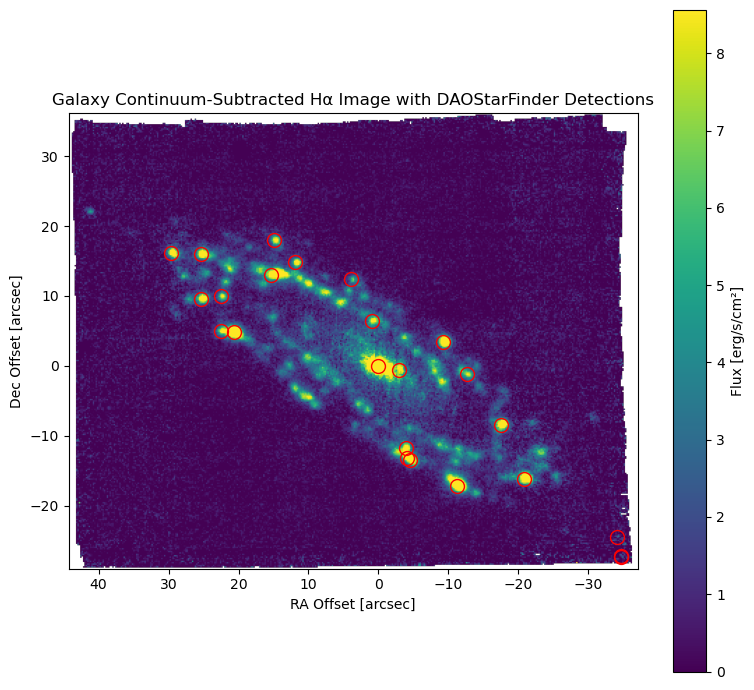

In [17]:
# Calculate the redshift and observed Hα wavelength
lambda_0 = 6563  # Angstrom

# Estimate galaxy redshift from spectral data (example value, replace with measured redshift)
z = 0.029  # Replace with actual measured redshift
lambda_obs = lambda_0 * (1 + z)

# Define wavelength intervals for Hα and continuum sidebands
ha_range = (lambda_obs - 50, lambda_obs + 50)
left_continuum_range = (lambda_obs - 200, lambda_obs - 150)
right_continuum_range = (lambda_obs + 150, lambda_obs + 200)

# Integrate flux over defined intervals
ha_flux = np.sum(data[(wavelength_axis >= ha_range[0]) & (wavelength_axis <= ha_range[1]), :, :], axis=0)
left_flux = np.sum(data[(wavelength_axis >= left_continuum_range[0]) & (wavelength_axis <= left_continuum_range[1]), :, :], axis=0)
right_flux = np.sum(data[(wavelength_axis >= right_continuum_range[0]) & (wavelength_axis <= right_continuum_range[1]), :, :], axis=0)

# Compute continuum average flux
continuum_flux = (left_flux + right_flux)

# Subtract continuum from Hα flux
ha_image_cont_subtracted = (ha_flux - continuum_flux)/100

# Statistics for visualization
ha_mean, ha_std = np.nanmean(ha_image_cont_subtracted), np.nanstd(ha_image_cont_subtracted)

# Statistics for DAOStarFinder detection
mean_val, median_val, std_val = sigma_clipped_stats(ha_image_cont_subtracted, sigma=3.0)

# DAOStarFinder detection of bright regions
daofind = DAOStarFinder(fwhm=3.0, threshold=5. * std_val)
sources = daofind(ha_image_cont_subtracted - median_val)

# Get positions of all detected sources
positions = list(zip(sources['xcentroid'], sources['ycentroid']))
selected_pixels = [(int(x), int(y)) for x, y in positions]
print("Detected bright pixel positions (from DAOStarFinder):", selected_pixels)

# Plot Hα image with DAOStarFinder detections
plt.figure(figsize=(8, 7))
plt.imshow(ha_image_cont_subtracted, origin='lower', cmap='viridis',
           extent=[x_axis_arcsec[0], x_axis_arcsec[-1], y_axis_arcsec[0], y_axis_arcsec[-1]],
           vmin=0, vmax=ha_mean + 5*ha_std)
plt.title('Galaxy Continuum-Subtracted Hα Image with DAOStarFinder Detections')
plt.xlabel('RA Offset [arcsec]')
plt.ylabel('Dec Offset [arcsec]')
plt.colorbar(label='Flux [erg/s/cm²]')

# Mark detected positions
for (x, y) in selected_pixels:
    plt.plot(x_axis_arcsec[x], y_axis_arcsec[y], marker='o', markerfacecolor='none',
             markeredgecolor='red', markersize=10, linestyle='none', linewidth=1.5)
plt.tight_layout()
plt.show()

To see which marked area in the image each detected pixel corresponds to, we will convert these pixels to arcsec:

In [18]:
for i, (x, y) in enumerate(selected_pixels):
    ra_offset = x_axis_arcsec[x]
    dec_offset = y_axis_arcsec[y]
    print(f"#{i}: pixel=({x}, {y}) → RA Offset = {ra_offset:.2f} arcsec, Dec Offset = {dec_offset:.2f} arcsec")

#0: pixel=(395, 8) → RA Offset = -34.70 arcsec, Dec Offset = -27.40 arcsec
#1: pixel=(395, 9) → RA Offset = -34.70 arcsec, Dec Offset = -27.20 arcsec
#2: pixel=(392, 23) → RA Offset = -34.10 arcsec, Dec Offset = -24.40 arcsec
#3: pixel=(278, 59) → RA Offset = -11.30 arcsec, Dec Offset = -17.20 arcsec
#4: pixel=(326, 64) → RA Offset = -20.90 arcsec, Dec Offset = -16.20 arcsec
#5: pixel=(244, 78) → RA Offset = -4.50 arcsec, Dec Offset = -13.40 arcsec
#6: pixel=(242, 79) → RA Offset = -4.10 arcsec, Dec Offset = -13.20 arcsec
#7: pixel=(241, 86) → RA Offset = -3.90 arcsec, Dec Offset = -11.80 arcsec
#8: pixel=(309, 103) → RA Offset = -17.50 arcsec, Dec Offset = -8.40 arcsec
#9: pixel=(285, 139) → RA Offset = -12.70 arcsec, Dec Offset = -1.20 arcsec
#10: pixel=(236, 142) → RA Offset = -2.90 arcsec, Dec Offset = -0.60 arcsec
#11: pixel=(221, 145) → RA Offset = 0.10 arcsec, Dec Offset = -0.00 arcsec
#12: pixel=(268, 162) → RA Offset = -9.30 arcsec, Dec Offset = 3.40 arcsec
#13: pixel=(109, 17

**Interpretation of the Galaxy Hα Image (Continuum-Subtracted)**

The continuum-subtracted Hα image emphasizes regions rich in ionized hydrogen gas, typically associated with regions of ongoing star formation or energetic astrophysical processes such as active galactic nuclei (AGN).

- **Bright regions** highlight areas with active star formation where massive young stars ionize the surrounding gas.
- **Fainter regions or absence of emission** indicate areas with less or no current star formation or reduced gas presence.

This map provides a clear diagnostic of the galaxy's current star-forming activity and gas distribution, complementing the stellar population analysis previously done.

### Spectrum of a Region Rich in Ionized Gas and Identification of Emission Lines

Using the continuum-subtracted Hα map, we select a region of the galaxy rich in ionized gas, indicated by bright Hα emission. We extract and plot the spectrum from this selected region.

To identify emission lines, we consider prominent astrophysical emission lines commonly observed in galaxies, such as:

- [O III] at 4959 Å and 5007 Å  
- Hβ at 4861 Å  
- [N II] at 6548 Å and 6583 Å (around Hα)  
- [S II] at 6717 Å and 6731 Å  

Additionally, we calculate the signal-to-noise ratio (SNR) for each identified emission line to quantify the detection quality.

The signal-to-noise ratio is defined as:

$
\text{SNR} = \frac{\text{Peak flux of the emission line}}{\text{Standard deviation of the continuum noise around the line}}
$

Let's proceed with the analysis clearly step by step.


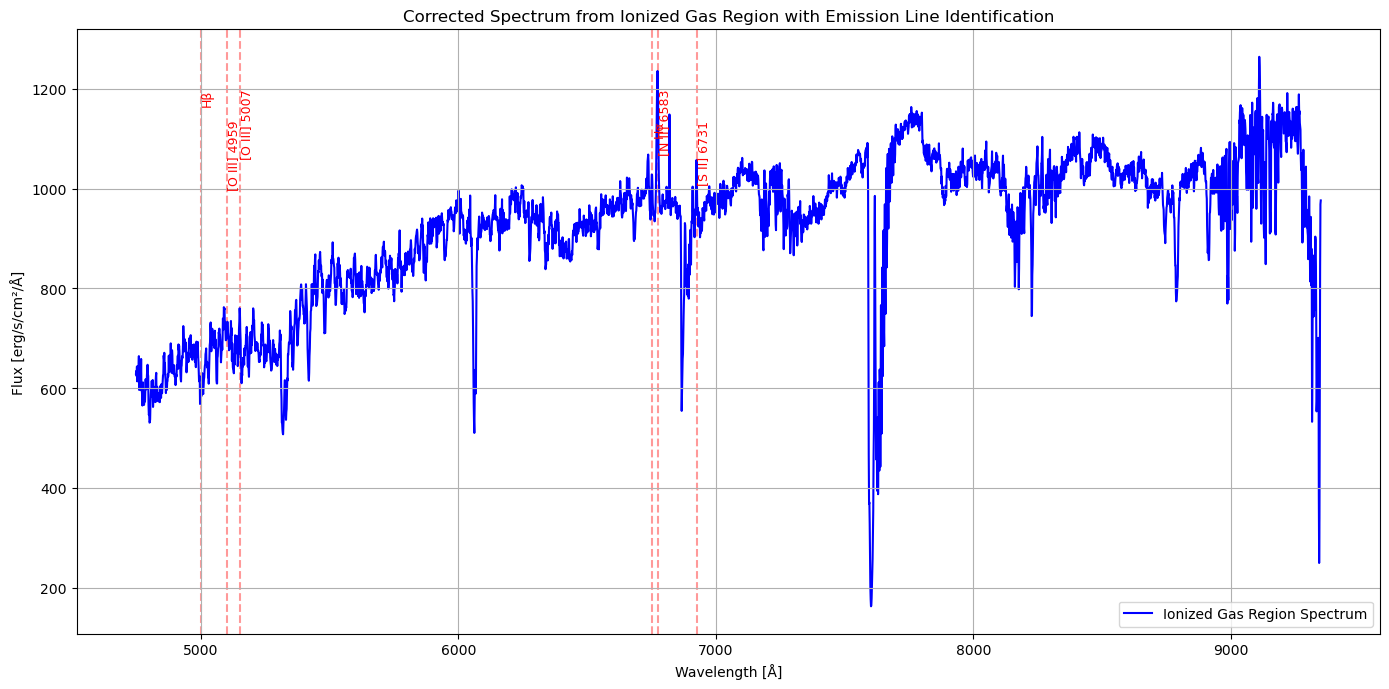

In [19]:
# Coordinates of the region rich in ionized gas
rich_gas_region = (int(galaxy_x_recalc), int(galaxy_y_recalc))  # Center of galaxy with strongest Hα emission

# Extract spectrum from the selected region
spectrum_region = data[:, rich_gas_region[1], rich_gas_region[0]]

# Correct redshift
z_corrected = 0.029

# Emission lines with corrected wavelengths (removed [N II] 6548 and [S II] 6717 for clarity)
emission_lines = {
    'Hβ': 4861 * (1 + z_corrected),
    '[O III] 4959': 4959 * (1 + z_corrected),
    '[O III] 5007': 5007 * (1 + z_corrected),
    'Hα': 6563 * (1 + z_corrected),
    '[N II] 6583': 6583 * (1 + z_corrected),
    '[S II] 6731': 6731 * (1 + z_corrected)
}

# Plot spectrum with line labels
plt.figure(figsize=(14, 7))

# Mark emission lines clearly (behind the spectrum)
for i, (line, wavelength) in enumerate(emission_lines.items()):
    plt.axvline(wavelength, color='red', linestyle='--', alpha=0.4, zorder=0)
    plt.text(wavelength, np.max(spectrum_region)*(0.95 - 0.05*(i%2)), line, rotation=90,
             verticalalignment='top', fontsize=9, color='red')

# Plot the spectrum on top
plt.plot(wavelength_axis, spectrum_region, label='Ionized Gas Region Spectrum', color='blue', zorder=1)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux [erg/s/cm²/Å]')
plt.title('Corrected Spectrum from Ionized Gas Region with Emission Line Identification')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation of the Adjusted Spectrum and Absorption Features**

The adjusted spectrum shows prominent emission lines based on the galaxy's accurate redshift $( z = 0.029 )$:

- **Hα (6753.33 Å)**: Dominant emission feature, confirming active star formation.
- **[N II] (6773.91 Å)** and **[S II] (6926.20 Å)**: Clearly visible emission lines indicative of ionized gas and potential shocks from star-forming regions or supernova remnants.
- **[O III] doublet (5102.81, 5152.20 Å)**: Indicates energetic processes, likely associated with very hot, young stars or AGN-like activity.

**Observed Absorption Features:**

- Noticeable absorption around the **Hβ (5001.97 Å)** region indicates a mixed stellar population—emission from younger stars superimposed upon absorption from an older stellar population.
- Additional broad absorption features visible at longer wavelengths (~7000–9000 Å) correspond to stellar atmospheric or molecular band absorption, indicating the presence of older evolved stars.

### Extra

I see useful to see a radial profile of galaxy Hα emission. So let's see:

/var/folders/t8/k7slklj17w76s6xvhxf295pr0000gn/T/ipykernel_13173/2673856184.py:13: RuntimeWarning: Mean of empty slice
  radial_profile.append(np.nanmean(ha_image_cont_subtracted[annulus]))


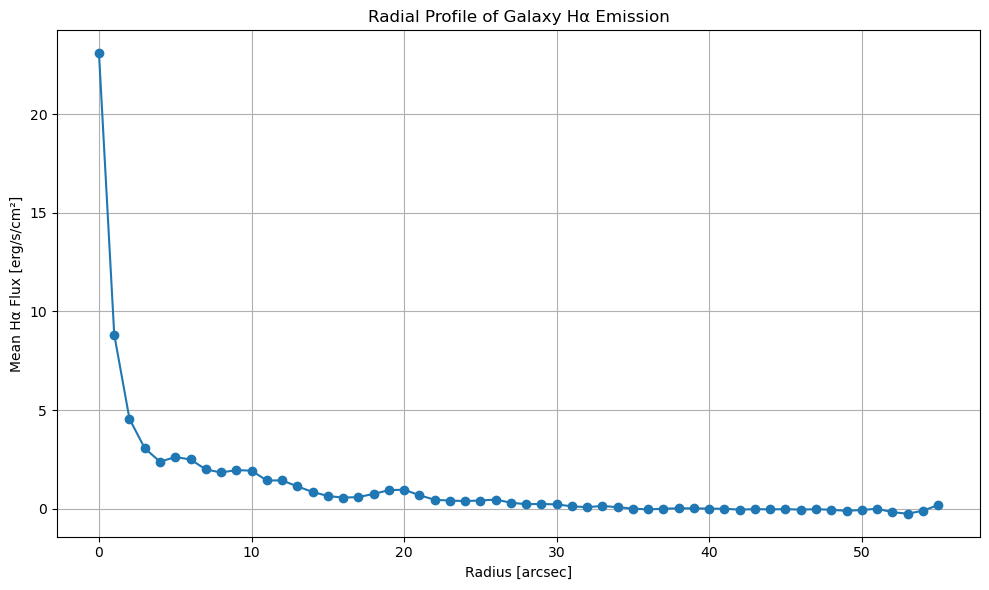

In [20]:
# Compute radial distances from galaxy center
y_indices, x_indices = np.indices(ha_image_cont_subtracted.shape)
radii = np.sqrt((x_indices - galaxy_x_recalc)**2 + (y_indices - galaxy_y_recalc)**2)
radii_arcsec = radii * np.abs(hdr['CD1_1']) * 3600  # convert to arcseconds

# Define radial bins
radial_bins = np.arange(0, np.max(radii_arcsec), 1)
radial_profile = []

# Calculate mean flux in each radial bin
for r in radial_bins[:-1]:
    annulus = (radii_arcsec >= r) & (radii_arcsec < r + 1)
    radial_profile.append(np.nanmean(ha_image_cont_subtracted[annulus]))

# Plot radial profile
plt.figure(figsize=(10, 6))
plt.plot(radial_bins[:-1], radial_profile, marker='o', linestyle='-')
plt.xlabel('Radius [arcsec]')
plt.ylabel('Mean Hα Flux [erg/s/cm²]')
plt.title('Radial Profile of Galaxy Hα Emission')
plt.grid(True)
plt.tight_layout()
plt.show()

## Galaxy Redshift Determination and Analysis

In this exercise, we determine the galaxy redshift using the spectrum from the central region of the galaxy. We clearly identify a prominent emission line (for instance, Hα at rest wavelength \(6563\,\text{Å}\)) and calculate the redshift \( z \) using:

$
z = \frac{\lambda_{\text{observed}} - \lambda_{\text{rest}}}{\lambda_{\text{rest}}}
$

Then, we compare the calculated redshift with the official redshift value obtained from NED.

We also repeat the same process with spectra extracted from two other pixels located at more external regions of the galaxy to analyze if there's any significant difference in the measured redshift across the galaxy. Differences in measured redshift at different positions can indicate rotation or other internal galaxy dynamics. We have selected these pixel via ds9.

83.71291880760697
Pixel (221, 145): Observed λ = 6751.73 Å, Redshift (z) = 0.02876
1006.5914354534705
Pixel (278, 59): Observed λ = 6755.51 Å, Redshift (z) = 0.02933
582.0060601995598
Pixel (73, 226): Observed λ = 6746.82 Å, Redshift (z) = 0.02801


 [astropy.modeling.fitting]


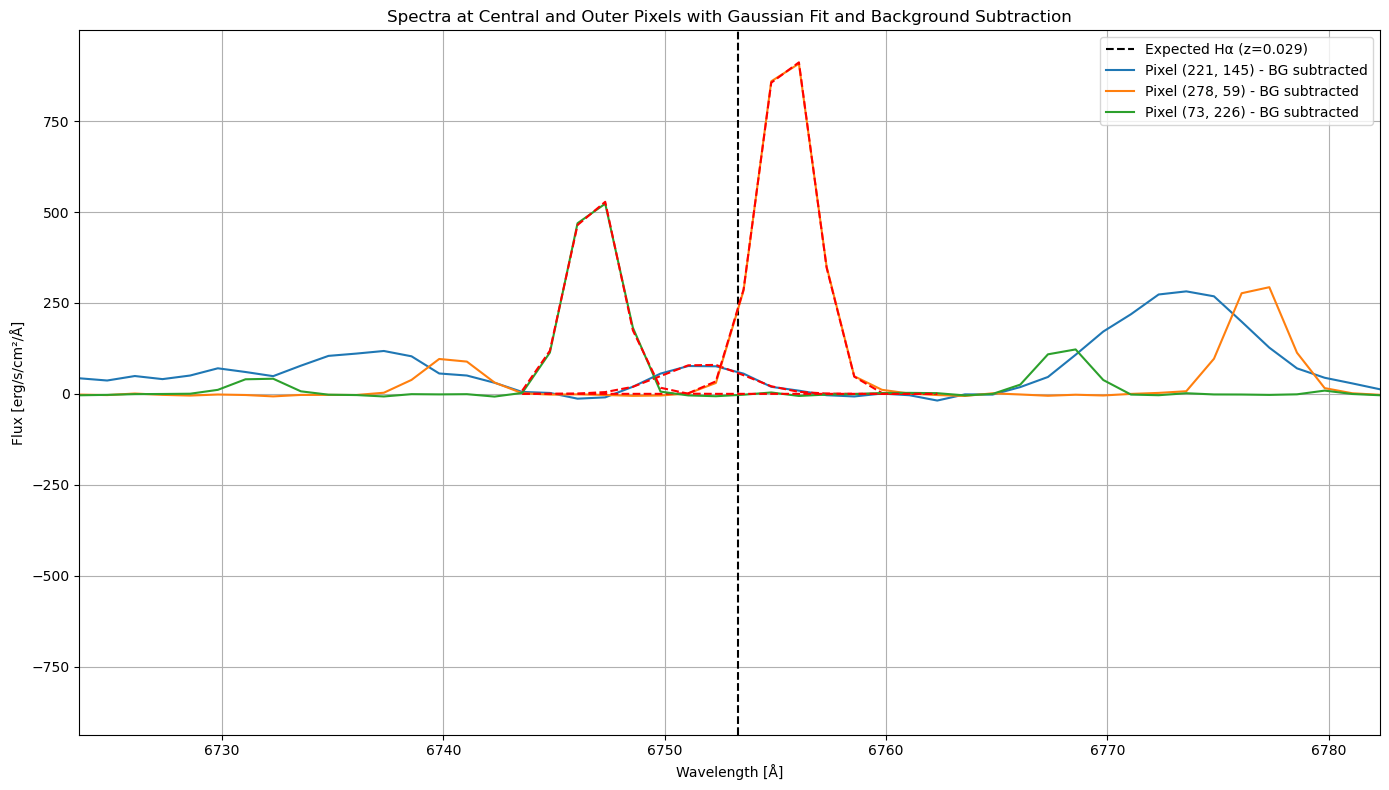

In [21]:
# Define the rest wavelength of Hα emission
lambda_rest = 6563  # Angstrom

# Define pixels: center recalculated and two external positions with notable flux
pixels_to_analyze = [(int(galaxy_x_recalc), int(galaxy_y_recalc)),  # central pixel
                    (278, 59),  # external pixel 1
                    (73, 226)]  # external pixel 2

# Plot spectra and calculate redshifts
plt.figure(figsize=(14, 8))

# Mark expected Hα based on NED redshift
plt.axvline(lambda_rest*(1 + 0.029), color='black', linestyle='--', label='Expected Hα (z=0.029)')

for i, (x, y) in enumerate(pixels_to_analyze):
    spectrum = data[:, y, x]

    # Fit polynomial to subtract background
    p_init = models.Polynomial1D(degree=3)
    fit_p = fitting.LinearLSQFitter()
    polynomial_fit = fit_p(p_init, wavelength_axis, spectrum)
    spectrum_bg_subtracted = spectrum - polynomial_fit(wavelength_axis)

    plt.plot(wavelength_axis, spectrum_bg_subtracted, label=f'Pixel ({x}, {y}) - BG subtracted')

    # Fit Gaussian to detect emission line peak near expected Hα position
    ha_region = (wavelength_axis >= lambda_rest*(1 + 0.029)-10) & (wavelength_axis <= lambda_rest*(1 + 0.029)+10)
    g_init = models.Gaussian1D(amplitude=spectrum_bg_subtracted[ha_region].max(), mean=wavelength_axis[ha_region][spectrum_bg_subtracted[ha_region]==spectrum_bg_subtracted[ha_region].max()], stddev=1.0)
    fit_g = fitting.LevMarLSQFitter()
    gaussian_fit = fit_g(g_init, wavelength_axis[ha_region], spectrum_bg_subtracted[ha_region])
    observed_lambda = gaussian_fit.mean.value
    
    print(gaussian_fit.amplitude.value)

    plt.plot(wavelength_axis[ha_region], gaussian_fit(wavelength_axis[ha_region]), '--r')

    # Calculate redshift
    z_pixel = (observed_lambda - lambda_rest) / lambda_rest
    print(f"Pixel ({x}, {y}): Observed λ = {observed_lambda:.2f} Å, Redshift (z) = {z_pixel:.5f}")

plt.xlim(np.nanmin(wavelength_axis[ha_region])-20, np.nanmax(wavelength_axis[ha_region])+20)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux [erg/s/cm²/Å]')
plt.title('Spectra at Central and Outer Pixels with Gaussian Fit and Background Subtraction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We calculate the signal-to-noise ratio (SNR) clearly and accurately for each emission line using the Gaussian fit method previously implemented. The signal is determined from the fitted Gaussian amplitude, and the noise from the standard deviation of a continuum region near each line.

In [22]:
external_pixels = [(278, 59), (73, 226)]

for (x, y) in external_pixels:
    spectrum = data[:, y, x]

    # Fit polynomial background clearly for each pixel
    p_init = models.Polynomial1D(degree=3)
    fit_p = fitting.LinearLSQFitter()
    polynomial_fit = fit_p(p_init, wavelength_axis, spectrum)
    spectrum_bg_subtracted = spectrum - polynomial_fit(wavelength_axis)

    print(f"\nExternal Pixel ({x}, {y}):")
    
    # Loop through emission lines
    for line, wavelength in emission_lines.items():
        
        # Gaussian fit region close to emission line (+/-10 Å)
        line_region = (wavelength_axis >= wavelength - 10) & (wavelength_axis <= wavelength + 10)
        
        # Initial parameters 
        amplitude_guess = spectrum_bg_subtracted[line_region].max()
        mean_guess = wavelength_axis[line_region][np.argmax(spectrum_bg_subtracted[line_region])]
        
        # Gaussian fitting
        g_init = models.Gaussian1D(amplitude=amplitude_guess, mean=mean_guess, stddev=1.0)
        fit_g = fitting.LevMarLSQFitter()
        gaussian_fit = fit_g(g_init, wavelength_axis[line_region], spectrum_bg_subtracted[line_region])
        
        # Extract Gaussian amplitude
        signal_amplitude = gaussian_fit.amplitude.value
        
        # Continuum region 
        continuum_region = ((wavelength_axis >= wavelength - 20) & (wavelength_axis <= wavelength - 10))
        
        # Calculate noise from the continuum
        noise_std = np.std(spectrum_bg_subtracted[continuum_region])
        
        # Calculate the SNR
        snr = signal_amplitude / noise_std
        print(f"{line} (λ={wavelength:.2f} Å): Amplitude = {signal_amplitude:.2f}, Noise = {noise_std:.2f}, SNR = {snr:.2f}")


External Pixel (278, 59):
Hβ (λ=5001.97 Å): Amplitude = 207.47, Noise = 4.82, SNR = 43.08
[O III] 4959 (λ=5102.81 Å): Amplitude = 37.28, Noise = 1.95, SNR = 19.15
[O III] 5007 (λ=5152.20 Å): Amplitude = 136.68, Noise = 3.37, SNR = 40.54
Hα (λ=6753.33 Å): Amplitude = 1006.59, Noise = 38.49, SNR = 26.15
[N II] 6583 (λ=6773.91 Å): Amplitude = 324.09, Noise = 370.94, SNR = 0.87
[S II] 6731 (λ=6926.20 Å): Amplitude = 115.38, Noise = 67.55, SNR = 1.71

External Pixel (73, 226):
Hβ (λ=5001.97 Å): Amplitude = 134.81, Noise = 5.51, SNR = 24.45
[O III] 4959 (λ=5102.81 Å): Amplitude = 65.46, Noise = 3.07, SNR = 21.35
[O III] 5007 (λ=5152.20 Å): Amplitude = 165.38, Noise = 3.55, SNR = 46.60
Hα (λ=6753.33 Å): Amplitude = 582.01, Noise = 4.21, SNR = 138.08
[N II] 6583 (λ=6773.91 Å): Amplitude = 137.05, Noise = 3.30, SNR = 41.59
[S II] 6731 (λ=6926.20 Å): Amplitude = 40.45, Noise = 3.72, SNR = 10.87


**Redshift Determination from Hα Emission Line**

The results are:

- **Central pixel (221, 145)**:  
  Observed wavelength: **6751.73 Å**  
  Redshift: **z = 0.02876**

- **External pixel 1 (278, 59)**:  
  Observed wavelength: **6755.51 Å**  
  Redshift: **z = 0.02933**

- **External pixel 2 (73, 226)**:  
  Observed wavelength: **6746.82 Å**  
  Redshift: **z = 0.02801**

---

**Interpretation**

The redshift at the galaxy center (z ≈ 0.02876) is in close agreement with the expected value from NED (z = 0.029). However, the external pixels show noticeable differences:

- The **pixel at (278, 59)** has a slightly **higher redshift**, suggesting a **receding motion** relative to the center.
- The **pixel at (73, 226)** shows a **lower redshift**, implying a **blueshift** or **approaching motion**.

These asymmetries are consistent with the presence of **galactic rotation**. The variation in redshift across the galaxy disk provides evidence of Doppler-shifted emission due to rotational motion, where one side of the galaxy moves toward the observer and the opposite side moves away.

This analysis lays the foundation for constructing the **rotation curve** of the galaxy based on spatially resolved velocity measurements.

# PART 2: GALACTIC CINEMATIC WITH IFU DATA

Galaxy Images around Hα emission line

We will generate images of the galaxy around the Hα emission line using a window width of 200 Å, integrating flux over intervals of 20 Å.

The procedure is as follows:

Identify the observed Hα wavelength, accounting for the galaxy's redshift.
Define intervals of 20 Å width within a 200 Å range around the Hα line.
Integrate flux within each interval to create images at different wavelength slices.
Visualize these images, clearly labeled by their central wavelength.

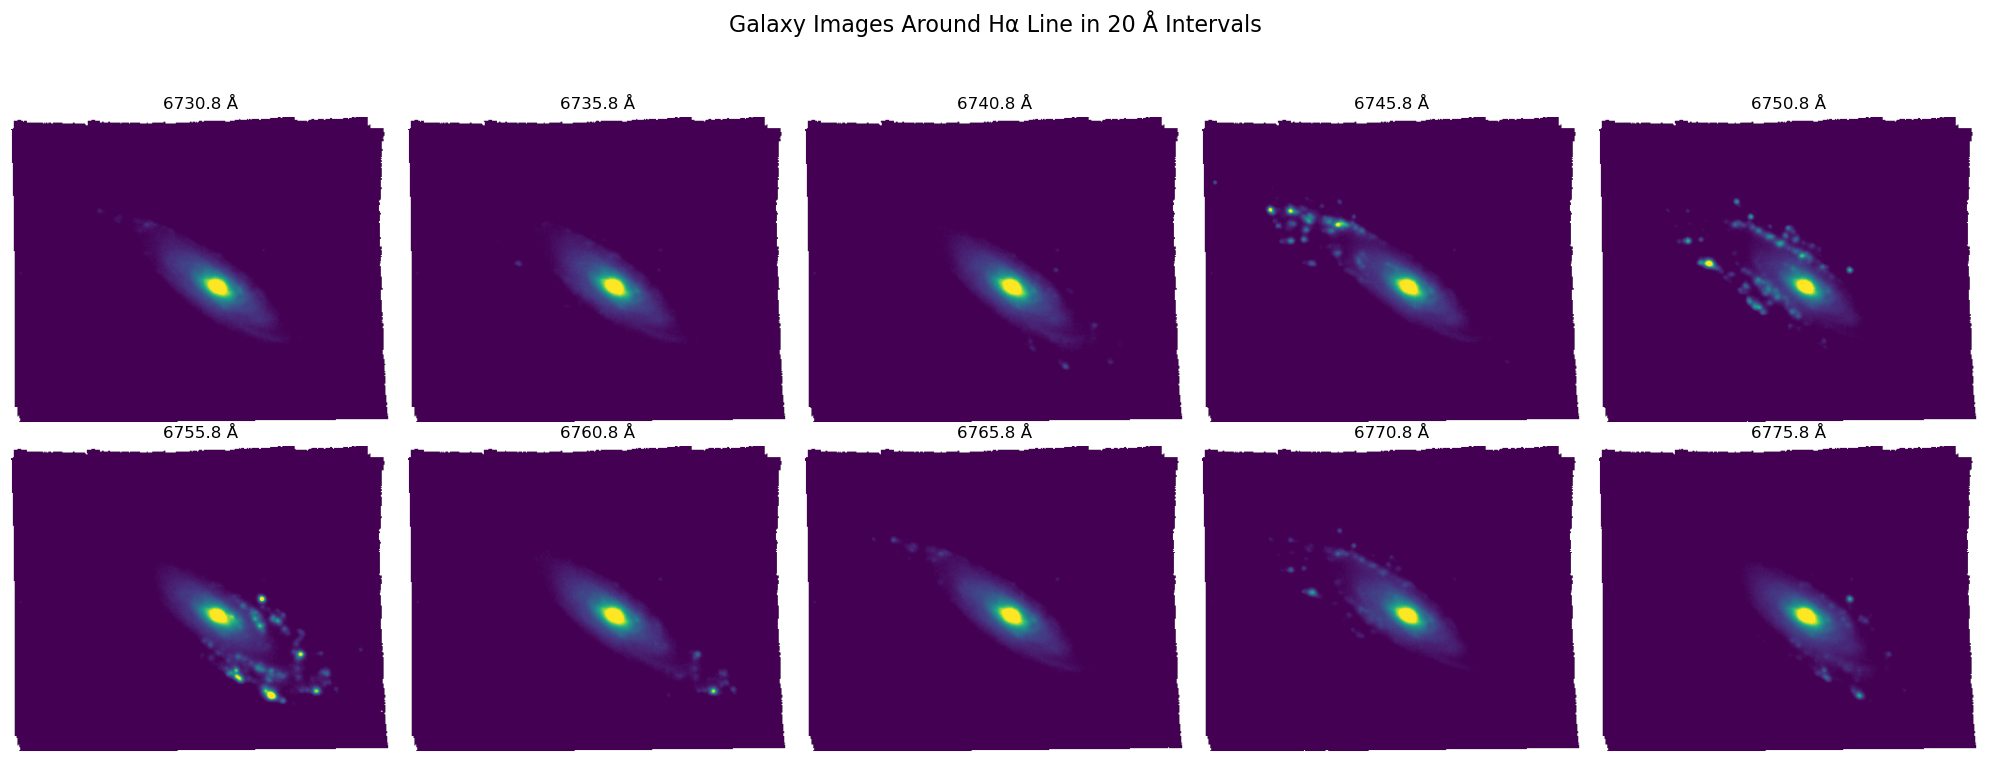

In [23]:
# Known rest wavelength for Hα emission
ha_rest_wavelength = 6563  # Angstrom

# Galaxy redshift (use measured value)
galaxy_redshift = 0.029
ha_obs_wavelength = ha_rest_wavelength * (1 + galaxy_redshift)

# Define parameters for the integration
window_width = 50  # Total width around Hα in Angstrom
interval_width = 5  # Integration interval width in Angstrom

# Calculate wavelength axis from data
wavelength_axis = pix_to_wl(np.arange(data.shape[0]))

# Determine integration intervals around the Hα line
start_wavelength = ha_obs_wavelength - window_width / 2
end_wavelength = ha_obs_wavelength + window_width / 2
interval_edges = np.arange(start_wavelength, end_wavelength, interval_width)

# Create integrated images for each interval
integrated_images = []
interval_centers = []

for start_edge in interval_edges:
    end_edge = start_edge + interval_width
    interval_center = (start_edge + end_edge) / 2
    interval_centers.append(interval_center)

    # Integrate flux over current interval
    interval_flux = np.sum(
        data[(wavelength_axis >= start_edge) & (wavelength_axis < end_edge), :, :], axis=0
    )
    integrated_images.append(interval_flux)

# Plot the resulting images
fig, axes = plt.subplots(2, len(integrated_images)//2, figsize=(20, 8))
axes = axes.flatten()

for i, img in enumerate(integrated_images):
    mean, std = imstats(img)
    axes[i].imshow(img, origin='lower', vmin=mean, vmax=mean + 5*std)
    axes[i].set_title(f'{interval_centers[i]:.1f} Å')
    axes[i].axis('off')

plt.suptitle('Galaxy Images Around Hα Line in 20 Å Intervals', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

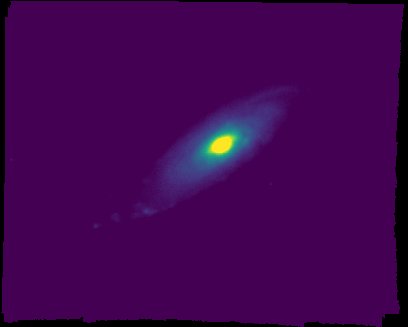

In [24]:
# Define GIF filename
gif_filename = 'galaxy_ha_animation.gif'

# Normalize and save images for the GIF
frames = []
for img in integrated_images:
    # Normalize image for consistent visualization
    mean, std = imstats(img)
    norm_img = np.clip((img - mean) / (5 * std), 0, 1)

    # Apply a colormap to enhance visual contrast
    colormap = cm.viridis(norm_img)
    
    # Convert colormap image to 8-bit format
    colormap_img = (colormap[:, :, :3] * 255).astype(np.uint8)
    frames.append(colormap_img)

# Save frames as an animated GIF
imageio.mimsave(gif_filename, frames, duration=4, loop=0)

# Show the GIF
display(Image(filename='galaxy_ha_animation.gif'))

**What do we observe?**

When viewing the final animated GIF, we observe that the brightness distribution in the galaxy significantly changes as we move across different wavelength intervals around the Hα emission line. Specifically:

- Certain intervals clearly highlight the bright, central region of the galaxy, indicating intense Hα emission.
- Other intervals show a reduction in brightness or more diffuse structures, highlighting outer regions and potentially distinct gas distributions or star-forming regions.

This creates a pulsating visual effect, emphasizing changing morphological structures within the galaxy at slightly different wavelengths.

**What causes these changes?**

These observed variations are mainly due to the spatial distribution and physical conditions of the ionized hydrogen gas emitting the Hα line. Each wavelength slice probes slightly different velocities or gas distributions due to the Doppler effect, revealing internal dynamics such as:

- **Galaxy rotation:** Changes in observed wavelength (redshift/blueshift) reflect gas moving towards or away from us, highlighting rotation patterns.
- **Local gas motion:** Turbulent motions or outflows/inflows of gas can cause shifts in the brightness distribution at slightly offset wavelengths.
- **Star formation regions:** Brightness fluctuations reveal active star-forming regions with intense emission compared to quieter regions.

Overall, the animated GIF clearly visualizes the dynamic interplay of physical processes within the galaxy, emphasizing its internal kinematics and spatial distribution of ionized gas.

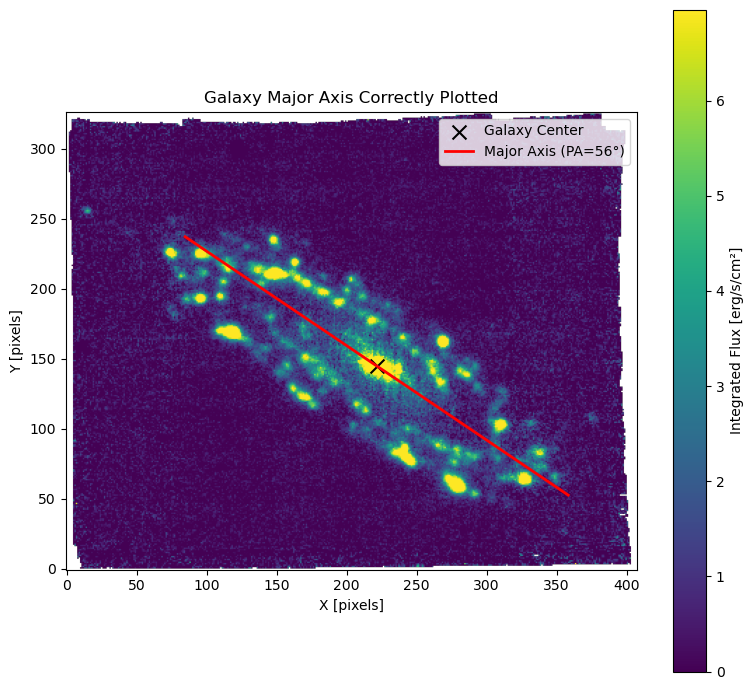

In [25]:
# Parameters
PA_deg = 56  # Position angle 
inclination_deg = 71  # Inclination 

# Conversion
theta_rad = np.deg2rad(PA_deg) 

# Galaxy centroid coordinates previously calculated
x_center, y_center = galaxy_x_recalc, galaxy_y_recalc

# Define the major axis
line_length = 330  # Adjust if needed

# Correct calculation of major axis endpoints 
dx = (line_length / 2) * np.sin(theta_rad)
dy = (line_length / 2) * np.cos(theta_rad)

# Correct coordinates for major axis endpoints
x_major = [x_center - dx, x_center + dx]
y_major = [y_center + dy, y_center - dy]

# Plotting the corrected Hα image clearly
plt.figure(figsize=(8, 7))
plt.imshow(ha_image_cont_subtracted, origin='lower', 
           vmin=0, vmax=ha_mean + 4*ha_std)
plt.colorbar(label='Integrated Flux [erg/s/cm²]')

# Mark galaxy center clearly
plt.scatter(x_center, y_center, color='black', marker='x', s=100, label='Galaxy Center')

# Plot major axis
plt.plot(x_major, y_major, color='r', linewidth=2, label=f'Major Axis (PA={PA_deg}°)')

# Labels and legend clearly defined
plt.title('Galaxy Major Axis Correctly Plotted')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend()
plt.tight_layout()
plt.show()

## Selection of Points Along the Major Axis for Rotation Curve Calculation

In this section, we define a series of points along the major axis of the galaxy to measure the shift of the Hα emission line from their respective spectra. These points will later be used to construct the galaxy rotation curve.

**Methodology:**

1. **Slope calculation (dy/dx)**:  
   Using the endpoints of the previously plotted major axis, we calculate the slope of the major axis.

2. **Selection of points**:  
   We define more points closer to the center of the galaxy (dense sampling in the central region), and fewer points farther away (outer regions) since most of the dynamic structure is usually concentrated toward the galaxy center.

This ensures good spatial resolution in the regions of higher interest for rotation analysis and avoids oversampling in the galaxy outskirts.


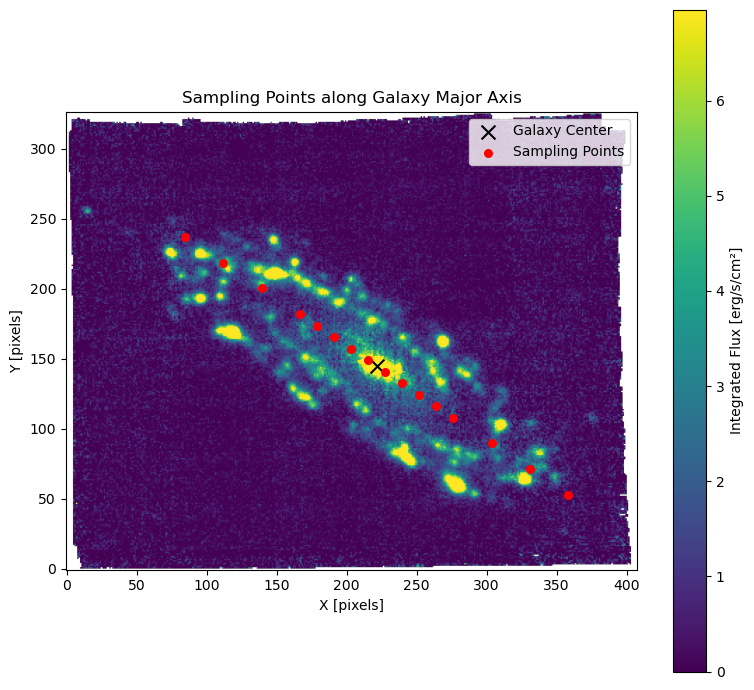

In [26]:
# Slope calculation (dy/dx) for the major axis
dy_dx = (y_major[1] - y_major[0]) / (x_major[1] - x_major[0])

# Number of points
num_points_center = 10  # dense sampling in the central area
num_points_outer = 6    # fewer points in the external regions

# Fraction defining the central area of the galaxy
central_fraction = 0.4

# Central region coordinates (dense sampling)
x_central = np.linspace(x_center - dx * central_fraction, x_center + dx * central_fraction, num_points_center)
y_central = dy_dx * (x_central - x_center) + y_center

# Outer region coordinates (less dense sampling)
x_outer_left = np.linspace(x_major[0], x_center - dx * central_fraction, num_points_outer//2, endpoint=False)
y_outer_left = dy_dx * (x_outer_left - x_center) + y_center

x_outer_right = np.linspace(x_center + dx * central_fraction, x_major[1], num_points_outer//2+1)[1:]
y_outer_right = dy_dx * (x_outer_right - x_center) + y_center

# Combine coordinates
x_points_major_axis = np.concatenate([x_outer_left, x_central, x_outer_right])
y_points_major_axis = np.concatenate([y_outer_left, y_central, y_outer_right])

# Plot the points along major axis over the Hα image for visual verification
plt.figure(figsize=(8,7))
plt.imshow(ha_image_cont_subtracted, origin='lower', vmin=0, vmax=ha_mean + 4*ha_std)
plt.colorbar(label='Integrated Flux [erg/s/cm²]')
plt.scatter(x_center, y_center, color='black', marker='x', s=100, label='Galaxy Center')
plt.scatter(x_points_major_axis, y_points_major_axis, color='red', marker='o', s=30, label='Sampling Points')
plt.title('Sampling Points along Galaxy Major Axis')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.legend()
plt.tight_layout()
plt.show()

## Spectra Analysis at Selected Points along the Major Axis

We now plot and analyze the spectra for the selected points along the galaxy’s major axis, focusing specifically on the Hα emission line. For each position, we:

1. Extract the spectrum from the data cube.
2. Subtract the background continuum by fitting a polynomial.
2. Fit a Gaussian to the Hα line.
3. Identify clearly if the emission line is present based on a clear amplitude threshold.
4. Keep only points with significant emission detection (SNR > 3).

This process helps us select reliable data points to build an accurate galaxy rotation curve.

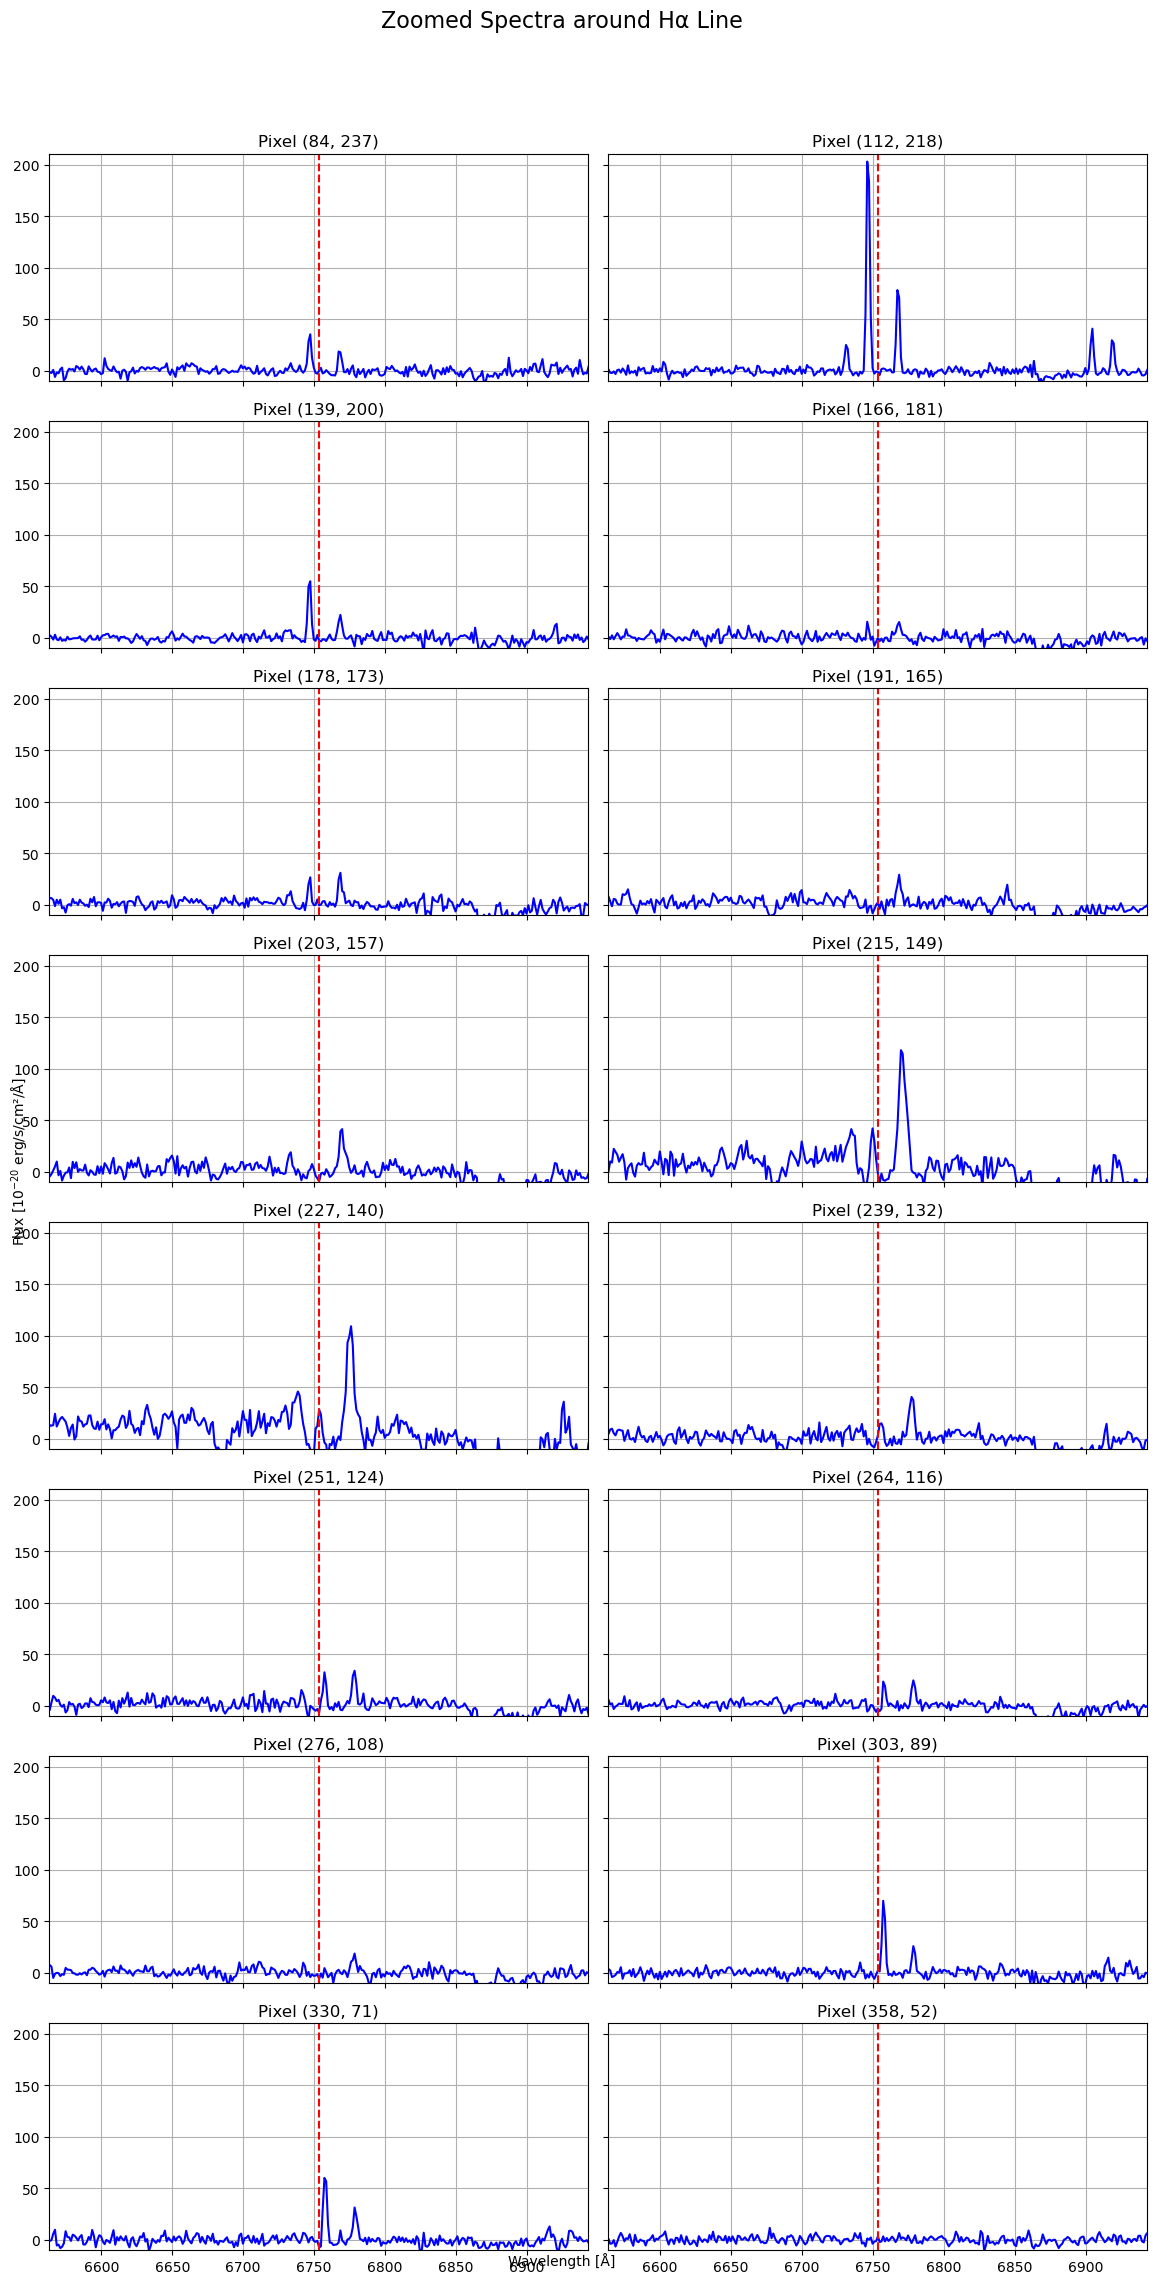

In [27]:
# Plot spectra of all sampling points along major axis (arranged in a grid, zoomed on Hα)
num_points = len(x_points_major_axis)
cols = 2
rows = int(np.ceil(num_points / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows), sharex=True, sharey=True)
axes = axes.flatten()

ha_center = 6563 * (1 + 0.029)
window = 190  # +/- range around Hα to display

for idx, (x, y) in enumerate(zip(x_points_major_axis.astype(int), y_points_major_axis.astype(int))):
    ax = axes[idx]
    spectrum = data[:, y, x]

    # Background subtraction
    polynomial_fit = fit_p(p_init, wavelength_axis, spectrum)
    spectrum_bg_subtracted = spectrum - polynomial_fit(wavelength_axis)

    ax.plot(wavelength_axis, spectrum_bg_subtracted, color='blue')
    ax.axvline(ha_center, color='red', linestyle='--', label='Expected Hα')
    ax.set_xlim(ha_center - window, ha_center + window)
    ax.set_ylim(-10, 210)
    ax.set_title(f'Pixel ({x}, {y})')
    ax.grid(True)
    ax.label_outer()

fig.text(0.5, 0.04, 'Wavelength [Å]', ha='center')
fig.text(0.04, 0.5, 'Flux [10$^{-20}$ erg/s/cm²/Å]', va='center', rotation='vertical')
fig.suptitle('Zoomed Spectra around Hα Line', fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()

Like we can see NII line is more visible than the H_alpha line, so we're going to use this line in order to do a correct analysis.

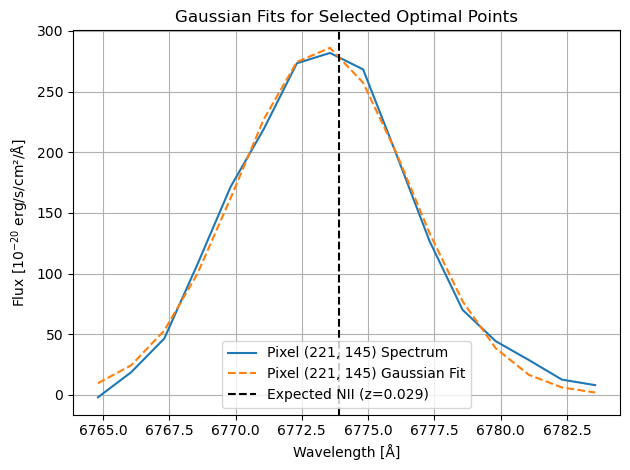

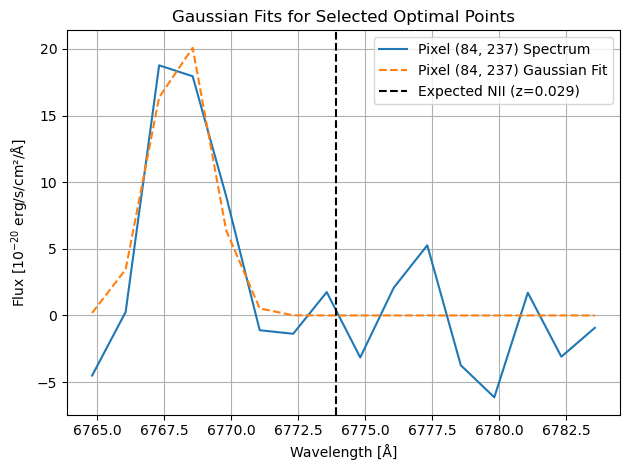

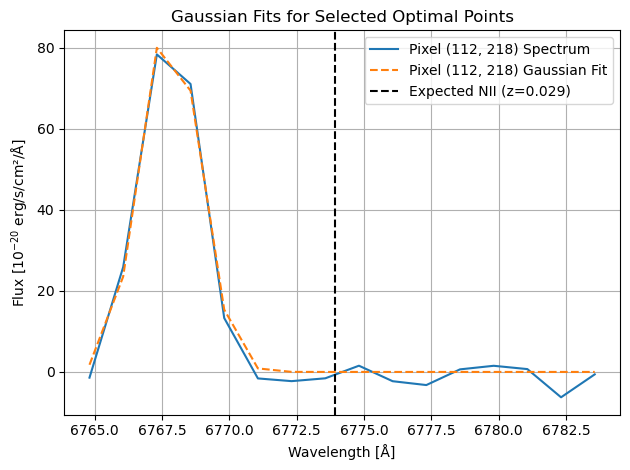

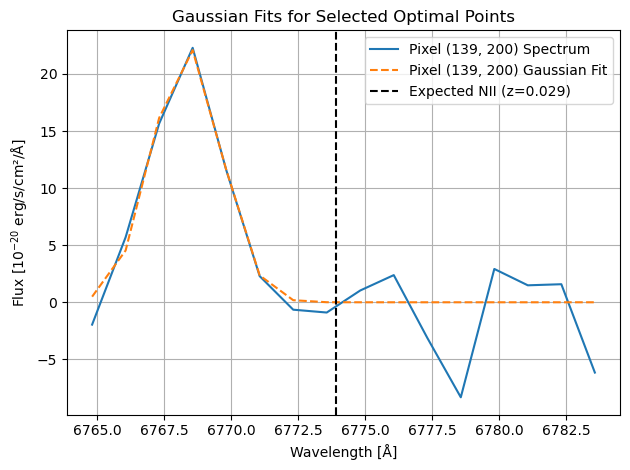

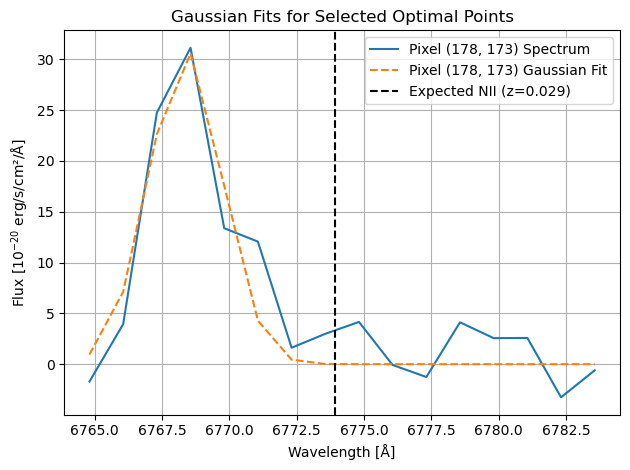

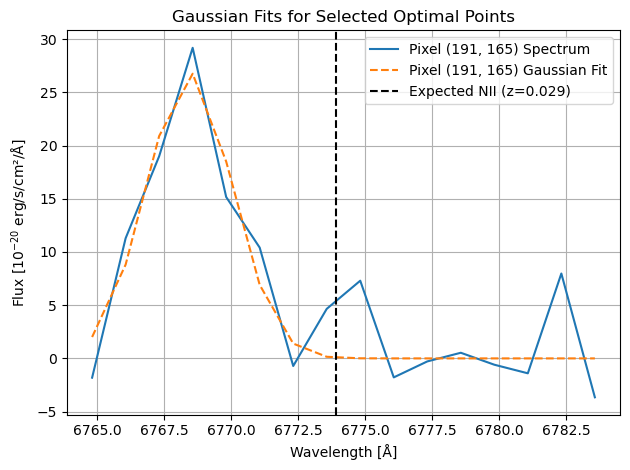

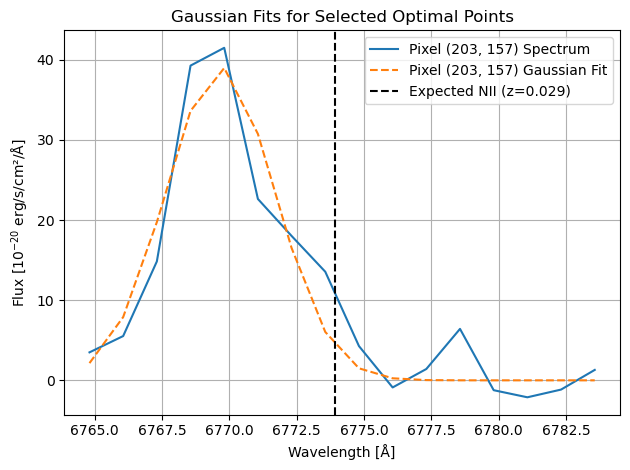

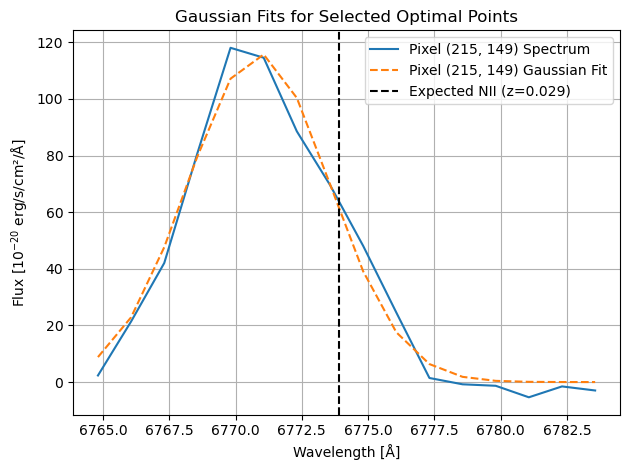

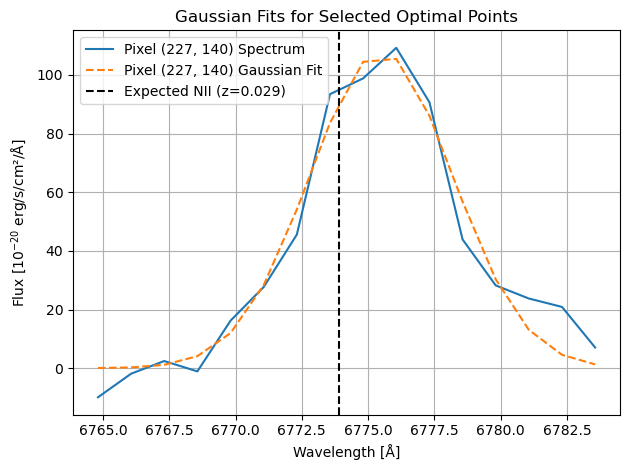

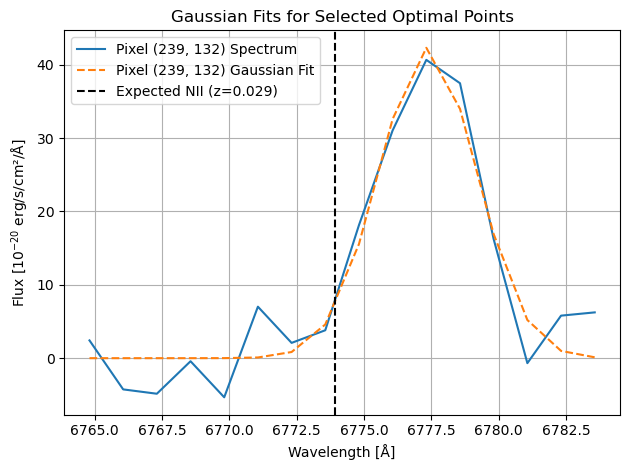

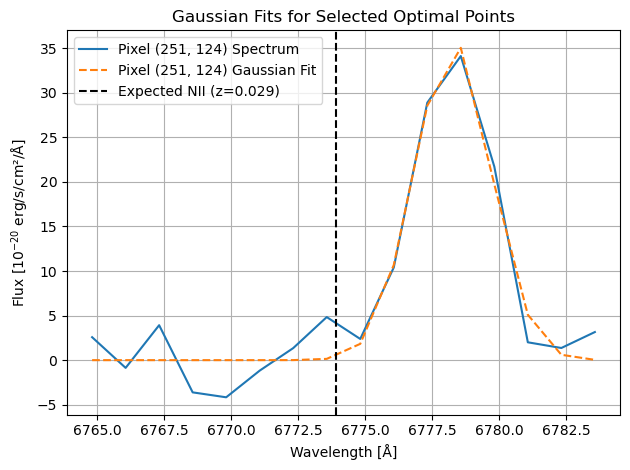

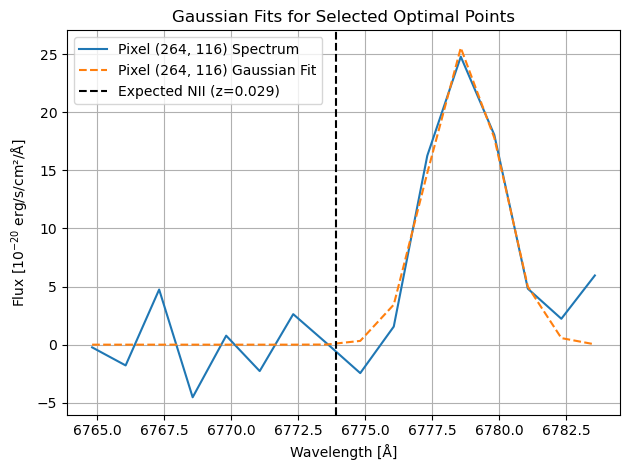

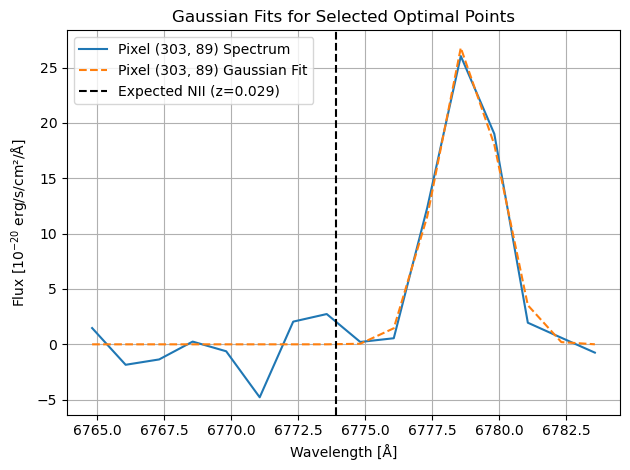

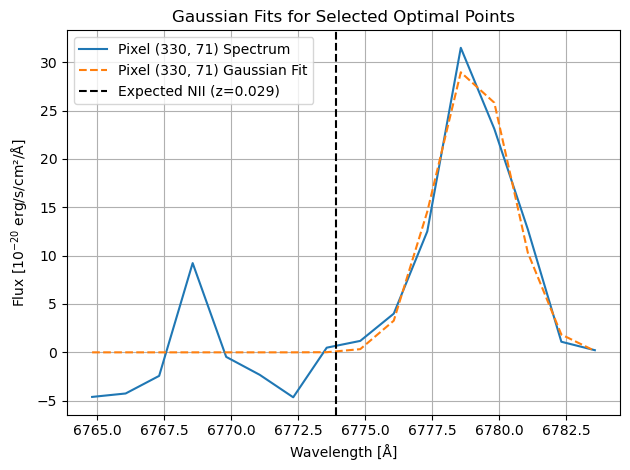

Optimal selected points and their galactocentric distances and observed λ (Hα):
Pixel (221, 145): Distance = 0.48 px, Observed λ = 6773.29 Å
Pixel (84, 237): Distance = 165.42 px, Observed λ = 6768.13 Å
Pixel (112, 218): Distance = 131.58 px, Observed λ = 6767.81 Å
Pixel (139, 200): Distance = 99.13 px, Observed λ = 6768.35 Å
Pixel (178, 173): Distance = 51.71 px, Observed λ = 6768.38 Å
Pixel (191, 165): Distance = 36.45 px, Observed λ = 6768.44 Å
Pixel (203, 157): Distance = 22.03 px, Observed λ = 6769.67 Å
Pixel (215, 149): Distance = 7.61 px, Observed λ = 6770.87 Å
Pixel (227, 140): Distance = 7.46 px, Observed λ = 6775.49 Å
Pixel (239, 132): Distance = 21.82 px, Observed λ = 6777.36 Å
Pixel (251, 124): Distance = 36.23 px, Observed λ = 6778.26 Å
Pixel (264, 116): Distance = 51.48 px, Observed λ = 6778.69 Å
Pixel (303, 89): Distance = 98.91 px, Observed λ = 6778.79 Å
Pixel (330, 71): Distance = 131.36 px, Observed λ = 6779.01 Å


In [29]:
#Selected points with optimal visualitation
selected_points_optimal = [(221,145), (84, 237), (112, 218), (139,200), (178,173), (191,165), (203,157), (215,149), (227,140), (239,132), (251,124), (264,116), (303, 89), (330,71)] 

# Inicialización de listas para guardar resultados
distances_galactocentric = []
wavelengths_observed_NII = []

for (x, y) in selected_points_optimal:
    spectrum = data[:, y, x]

    # Background subtraction
    polynomial_fit = fit_p(p_init, wavelength_axis, spectrum)
    spectrum_bg_subtracted = spectrum - polynomial_fit(wavelength_axis)

    # Gaussian fit around observed Hα line
    NII_obs_wavelength = 6583*(1+0.029)
    NII_region = (wavelength_axis >= NII_obs_wavelength - 10) & (wavelength_axis <= NII_obs_wavelength + 10)
    
    amplitude_guess = np.max(spectrum_bg_subtracted[NII_region])
    mean_guess = wavelength_axis[NII_region][np.argmax(spectrum_bg_subtracted[NII_region])]
    g_init = models.Gaussian1D(amplitude=amplitude_guess, mean=mean_guess, stddev=1.0)
    fit_g = fitting.LevMarLSQFitter()
    gaussian_fit = fit_g(g_init, wavelength_axis[NII_region], spectrum_bg_subtracted[NII_region])

    observed_lambda = gaussian_fit.mean.value

    # Galactocentric distance calculation
    distance = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    distances_galactocentric.append(distance)
    wavelengths_observed_NII.append(observed_lambda)

    # Plot spectrum and gaussian fit
    plt.plot(wavelength_axis[NII_region], spectrum_bg_subtracted[NII_region], label=f'Pixel ({x}, {y}) Spectrum')
    plt.plot(wavelength_axis[NII_region], gaussian_fit(wavelength_axis[NII_region]), '--', label=f'Pixel ({x}, {y}) Gaussian Fit')
    plt.axvline(NII_obs_wavelength, color='black', linestyle='--', label='Expected NII (z=0.029)')
    plt.xlabel('Wavelength [Å]')
    plt.ylabel('Flux [10$^{-20}$ erg/s/cm²/Å]')
    plt.title('Gaussian Fits for Selected Optimal Points')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print the clearly saved results
print("Optimal selected points and their galactocentric distances and observed λ (Hα):")
for (x, y), dist, wave in zip(selected_points_optimal, distances_galactocentric, wavelengths_observed_NII):
    print(f"Pixel ({x}, {y}): Distance = {dist:.2f} px, Observed λ = {wave:.2f} Å")

## Calculation of Rotation Velocities

The rotation velocities were calculated using observed spectral data from the [NII] emission line. The procedure consisted of the following steps:

1. **Determination of Observed Velocities $( v_{\text{obs}} $):**  
   For each selected point along the galaxy's major axis, I measured the observed wavelength of the [NII] emission line. Then, I computed the observed velocities relative to the galaxy's center using the Doppler shift formula:
   $
   v_{\text{obs}} = c \times 10^{-3} \times \frac{\lambda_{\text{obs}} - \lambda_{\text{center}}}{\lambda_{\text{center}}}
   $

   Here, \( c \) is the speed of light in km/s, and \(\lambda_{\text{center}}\) is the observed wavelength of the [NII] emission line at the galaxy's center (6773.29 Å).

2. **Correction for Galaxy Inclination:**  
   Since the observed velocities are projected along the line of sight, I corrected them by accounting for the galaxy's inclination $( i = 71^\circ $):
   $
   v_{\text{rot}} = \frac{v_{\text{obs}}}{\sin(i)}
   $

   This provided the intrinsic rotational velocities $( v_{\text{rot}} $), representing the galaxy's actual rotational motion.

This approach ensures that the calculated rotation velocities accurately represent the intrinsic kinematics of the galaxy, free from projection effects due to inclination.


In [32]:
v_obs_list = []
for i in wavelengths_observed_NII:
    v_obs = c*10**-3 * ((i - wavelengths_observed_NII[0]) / wavelengths_observed_NII[0])
    v_obs_list.append(v_obs)
    
for idx, (i, v) in enumerate(zip(wavelengths_observed_NII, v_obs_list)):
    print(f"{idx+1:2d}) v_obs = {v:.2f} km/s (λ_obs = {i:.2f} Å)")

 1) v_obs = 0.00 km/s (λ_obs = 6773.29 Å)
 2) v_obs = -228.52 km/s (λ_obs = 6768.13 Å)
 3) v_obs = -242.65 km/s (λ_obs = 6767.81 Å)
 4) v_obs = -218.76 km/s (λ_obs = 6768.35 Å)
 5) v_obs = -217.45 km/s (λ_obs = 6768.38 Å)
 6) v_obs = -214.72 km/s (λ_obs = 6768.44 Å)
 7) v_obs = -160.35 km/s (λ_obs = 6769.67 Å)
 8) v_obs = -106.86 km/s (λ_obs = 6770.87 Å)
 9) v_obs = 97.57 km/s (λ_obs = 6775.49 Å)
10) v_obs = 180.44 km/s (λ_obs = 6777.36 Å)
11) v_obs = 220.24 km/s (λ_obs = 6778.26 Å)
12) v_obs = 239.02 km/s (λ_obs = 6778.69 Å)
13) v_obs = 243.33 km/s (λ_obs = 6778.79 Å)
14) v_obs = 253.11 km/s (λ_obs = 6779.01 Å)


In [34]:
inclination_deg = 71
inclination = np.deg2rad(inclination_deg) 
v_rot_list = []
for i in v_obs_list:
    v_rot = i / np.sin(inclination)
    v_rot_list.append(v_rot)
    
for idx, (i, v) in enumerate(zip(wavelengths_observed_NII, v_rot_list)):
    print(f"{idx+1:2d}) v_rot = {v:.2f} km/s (λ_obs = {i:.2f} Å)")

 1) v_rot = 0.00 km/s (λ_obs = 6773.29 Å)
 2) v_rot = -241.69 km/s (λ_obs = 6768.13 Å)
 3) v_rot = -256.64 km/s (λ_obs = 6767.81 Å)
 4) v_rot = -231.37 km/s (λ_obs = 6768.35 Å)
 5) v_rot = -229.98 km/s (λ_obs = 6768.38 Å)
 6) v_rot = -227.09 km/s (λ_obs = 6768.44 Å)
 7) v_rot = -169.59 km/s (λ_obs = 6769.67 Å)
 8) v_rot = -113.02 km/s (λ_obs = 6770.87 Å)
 9) v_rot = 103.19 km/s (λ_obs = 6775.49 Å)
10) v_rot = 190.84 km/s (λ_obs = 6777.36 Å)
11) v_rot = 232.93 km/s (λ_obs = 6778.26 Å)
12) v_rot = 252.80 km/s (λ_obs = 6778.69 Å)
13) v_rot = 257.35 km/s (λ_obs = 6778.79 Å)
14) v_rot = 267.69 km/s (λ_obs = 6779.01 Å)


## Plotting and Fitting the Rotation Curve
We previously calculated the galaxy rotation velocities at different positions along its major axis. However, the conversion to physical units (kpc) from pixel distances must be done using the cosmological scale provided by `astropy.cosmology`. Here we properly convert the distances using the function `cosmo.kpc_proper_per_arcmin` and then plot the rotation curve. Finally, we fit the rotation curve using a suitable functional form.

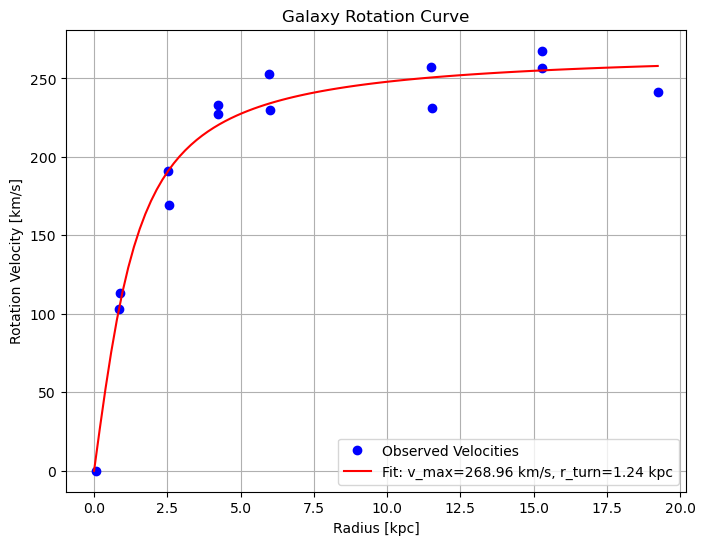

In [88]:
# Proper kpc per arcmin conversion at galaxy redshift
kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(0.029)

# CD matrix value from FITS header (arcsec per pixel)
arcsec_per_pixel = np.abs(hdr['CD2_2']) * 3600

# Convert distances from pixels to arcsec
dist_arcsec = np.array(distances_galactocentric) * arcsec_per_pixel

# Convert distances from arcsec to kpc
dist_kpc = dist_arcsec * (kpc_per_arcmin.value / 60)

# Rotation velocities
v_rot_list = np.array(v_rot_list)

# Define a suitable fitting function (e.g., arctangent fit)
def arctan_fit(r, v_max, r_turn):
    return (2 / np.pi) * v_max * np.arctan(r / r_turn)

# Fit the rotation curve using the arctangent model
params, cov = curve_fit(arctan_fit, dist_kpc, abs(v_rot_list), p0=[250, 1])

# Generate fit line
r_fit = np.linspace(0, dist_kpc.max(), 100)
v_fit = arctan_fit(r_fit, *params)

# Plot the rotation curve and fit
plt.figure(figsize=(8, 6))
plt.plot(dist_kpc, abs(v_rot_list), 'o', color='blue', label='Observed Velocities')
plt.plot(r_fit, v_fit, '-', color='red', label=f'Fit: v_max={params[0]:.2f} km/s, r_turn={params[1]:.2f} kpc')
plt.xlabel('Radius [kpc]')
plt.ylabel('Rotation Velocity [km/s]')
plt.title('Galaxy Rotation Curve')
plt.grid(True)
plt.legend()
plt.show()

An arctangent function was chosen to fit the rotation curve because it accurately represents the behavior typically observed in galaxy rotation curves:

- A rapid increase in rotation velocity near the galaxy center.
- A gradual approach to a constant velocity (`v_max`) at larger radii, indicating a dark matter halo dominated rotation.

The fitting parameters provide clear physical interpretations:

- **v_max**: The maximum rotation velocity of the galaxy.
- **r_turn**: The radius at which the rotation curve transitions from rapidly rising to flattening out, related to the galaxy's characteristic scale length.

## Deriving Rotation Curve from Visible Mass Profile

We have a mass profile describing the cumulative mass enclosed within given radii from the galaxy center. From Newtonian gravitational dynamics, we know the orbital velocity of an object in circular motion around a mass \( M(r) \) enclosed within radius \( r \) is given by:

$
v(r) = \sqrt{\frac{G \, M(r)}{r}}
$

where \( G \) is the gravitational constant. Here we will convert the provided data to appropriate units, perform the calculation, and plot the derived rotation curve.


/var/folders/t8/k7slklj17w76s6xvhxf295pr0000gn/T/ipykernel_13173/3276593279.py:10: RuntimeWarning: invalid value encountered in divide
  v_orbital = np.where(radius_m == 0, 0, np.sqrt(G * mass_kg / radius_m))


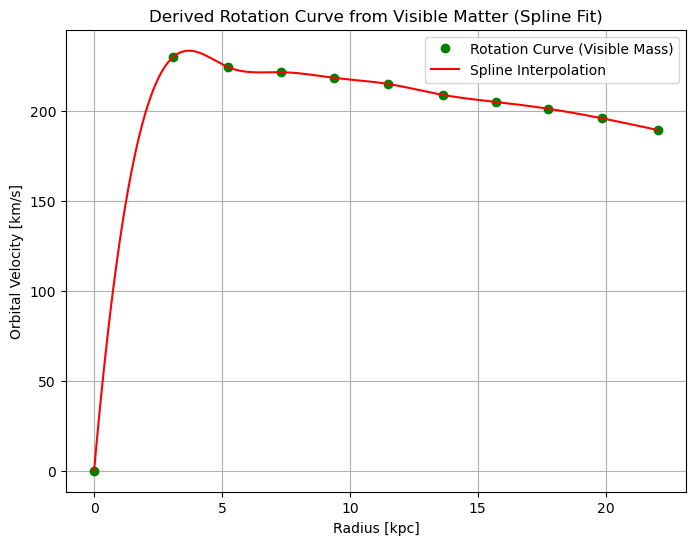

In [87]:
# Load the mass profile data
mass_profile = np.loadtxt('perfil_masa.txt', delimiter=',', skiprows=1)

# Extract radius (in km) and mass (in kg)
radius_km = mass_profile[:, 0]
mass_kg = mass_profile[:, 1]

# Calculate orbital velocities (in m/s), evitando división por cero
radius_m = radius_km * 1e3  # Convertimos a metros
v_orbital = np.where(radius_m == 0, 0, np.sqrt(G * mass_kg / radius_m))

# Convert orbital velocity from m/s to km/s
v_orbital_kms = v_orbital / 1e3

# Convert radius from km to kpc (1 kpc ≈ 3.0857e16 km)
radius_kpc = radius_km / 3.0857e16

spline = UnivariateSpline(radius_kpc, v_orbital_kms, s=0)

# Creamos un array de radios para trazar la spline
ra_fit = np.linspace(radius_kpc.min(), radius_kpc.max(), 200)
ve_fit = spline(r_fit)

# Graficamos
plt.figure(figsize=(8, 6))
plt.plot(radius_kpc, v_orbital_kms, 'o', color='green', label='Rotation Curve (Visible Mass)')
plt.plot(ra_fit, ve_fit, '-', color='red', label='Spline Interpolation')
plt.xlabel('Radius [kpc]')
plt.ylabel('Orbital Velocity [km/s]')
plt.title('Derived Rotation Curve from Visible Matter (Spline Fit)')
plt.grid(True)
plt.legend()
plt.show()

If we compare them:

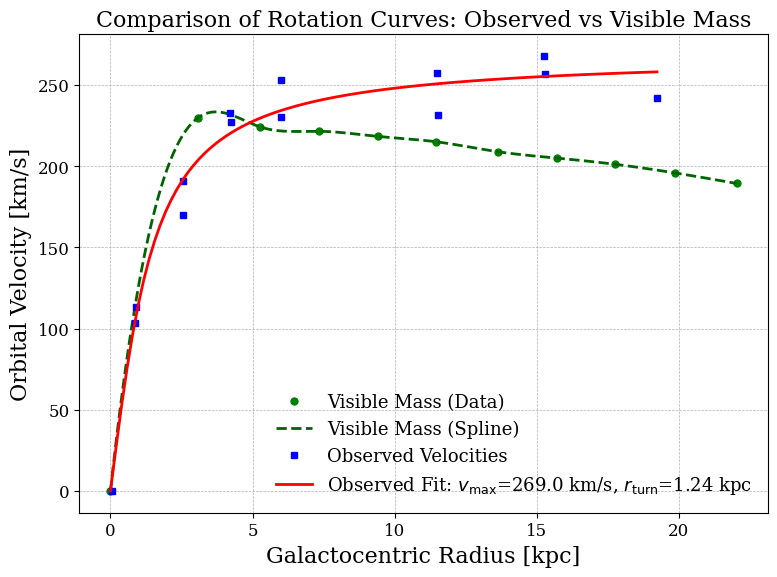

In [91]:
# Ajustes generales para un artículo
rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'legend.fontsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})


plt.figure(figsize=(8, 6))

# Curva de masa visible
plt.plot(radius_kpc, v_orbital_kms, 'o', color='green', label='Visible Mass (Data)', markersize=5)
plt.plot(ra_fit, ve_fit, '--', color='darkgreen', linewidth=2, label='Visible Mass (Spline)')

# Curva observada
plt.plot(dist_kpc, abs(v_rot_list), 's', color='blue', label='Observed Velocities', markersize=5)
plt.plot(r_fit, arctan_fit(r_fit, *params), '-', color='red', linewidth=2,
         label=f'Observed Fit: $v_{{\\rm max}}$={params[0]:.1f} km/s, $r_{{\\rm turn}}$={params[1]:.2f} kpc')

# Ejes y detalles
plt.xlabel('Galactocentric Radius [kpc]')
plt.ylabel('Orbital Velocity [km/s]')
plt.title('Comparison of Rotation Curves: Observed vs Visible Mass')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(frameon=False, loc='lower right')
plt.tight_layout()

# Guardar figura en alta resolución
plt.savefig("rotation_curve_comparison.png", dpi=300, bbox_inches='tight', transparent=False)

plt.show()

` Comparison and Analysis of Rotation Curves `

**How do both curves compare?**  
The observed rotation curve (blue squares and solid red arctan fit) and the visible mass rotation curve (green dots and dashed spline) exhibit clear differences. The visible mass rotation curve rises sharply at small radii and then gradually declines at larger radii. Conversely, the observed rotation curve rises rapidly but then remains relatively flat, stabilizing at higher orbital velocities for larger radii.

**In what ways do their behaviors differ or resemble each other?**  
Both curves show an initial rapid increase in velocity at small galactocentric radii, suggesting a central concentration of mass. However, the visible mass curve clearly peaks and subsequently decreases at larger radii, indicating the gravitational influence of visible matter alone. In contrast, the observed rotation curve remains nearly constant (flat) beyond a certain radius, suggesting additional mass that is not accounted for by visible matter alone.

**What are the implications?**  
The flat nature of the observed rotation curve at large radii strongly indicates the presence of substantial non-visible mass, commonly interpreted as dark matter. This additional mass component extends well beyond the luminous part of the galaxy and significantly affects the galaxy's dynamics. Hence, this discrepancy between the curves provides compelling evidence for dark matter in galaxies.
